## Instalaciones necesarias

In [ ]:
#%pip install plotly kaleido 
#%pip install bokeh matplotlib seaborn 
#%pip install nbformat
#%pip install torchsummary 

## Librerías

In [2]:
# Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image # Para abrir y examinar imágenes
import matplotlib.pyplot as plt
import seaborn as sns # Para visualizaciones de datos

from sklearn.model_selection import train_test_split

# Importar el módulo de redes neuronales de PyTorch
import torch.nn as nn
import torch.nn.functional as F # Para funciones de activación, pooling, etc.
from torchsummary import summary

# Importar librerías necesarias
import torch.nn as nn
import torch.optim as optim
import time
import os
import gc
import copy # Para copiar el mejor modelo/estado

# Importar librería Optuna
import optuna

import plotly.graph_objects as go
import optuna.visualization as vis

# Importar librerías necesarias para evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns # Para visualización de la matriz de confusión
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image # Para visualización (aunque ya cargadas por DataLoader)

## Configuración

In [ ]:
# Selección de Dispositivo (CPU/GPU)
# Selecciona el dispositivo PyTorch. Prioriza CUDA (GPU NVIDIA) si está disponible.
# Es crucial mover modelos y tensores a este dispositivo para aprovechar la GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")
if device.type == 'cuda':
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total de la GPU: {torch.cuda.get_device_properties(0).total_memory / (1024**2):.2f} MB") # Mostrar VRAM total
    # Limpiar caché de VRAM al inicio si es necesario (útil si re-ejecutas celdas)
    torch.cuda.empty_cache()
    print("Caché de VRAM limpiado.")

Dispositivo seleccionado: cuda
Nombre de la GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Memoria total de la GPU: 8187.50 MB
Caché de VRAM limpiado.


In [4]:

# 2. Definición de Rutas
# Define las rutas a los datos. Ajusta si tu estructura de directorios es diferente.
BASE_DATA_PATH = './Datos/'
CSV_FILE_PATH = os.path.join(BASE_DATA_PATH, 'train.csv')
IMAGE_DIR_PATH = os.path.join(BASE_DATA_PATH, 'images', 'images') # Ruta al directorio que CONTIENE las imágenes

print(f"\nRuta al archivo CSV: {CSV_FILE_PATH}")
print(f"Ruta al directorio de imágenes: {IMAGE_DIR_PATH}")

# Verificar si las rutas existen
if not os.path.exists(CSV_FILE_PATH):
    raise FileNotFoundError(f"El archivo CSV no se encontró en: {CSV_FILE_PATH}")
if not os.path.exists(IMAGE_DIR_PATH):
    raise FileNotFoundError(f"El directorio de imágenes no se encontró en: {IMAGE_DIR_PATH}")
print("Rutas verificadas. Archivos encontrados.")


Ruta al archivo CSV: ./Datos/train.csv
Ruta al directorio de imágenes: ./Datos/images\images
Rutas verificadas. Archivos encontrados.


## Análisis Exploratorio de Datos (EDA)

In [5]:
df_train = pd.read_csv(CSV_FILE_PATH)
print("\nDataFrame cargado exitosamente.")
print("Primeras 5 filas del DataFrame:")
print(df_train.head())
print("\nInformación del DataFrame:")
df_train.info()


DataFrame cargado exitosamente.
Primeras 5 filas del DataFrame:
           filename    class   xmin   ymin   xmax   ymax  object_count  \
0  image_00373.jpeg   cougar  506.0  303.0  628.0  414.0           1.0   
1  image_00065.jpeg  seahawk  381.0   35.0  856.0  273.0           1.0   
2  image_00111.jpeg   cougar  467.0  136.0  830.0  302.0           1.0   
3  image_00112.jpeg   cougar  447.0  122.0  799.0  287.0           1.0   
4  image_00113.jpeg   cougar  418.0  141.0  631.0  291.0           1.0   

       type  
0  original  
1  original  
2  original  
3  original  
4  original  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filename      300 non-null    object 
 1   class         300 non-null    object 
 2   xmin          189 non-null    float64
 3   ymin          189 non-null    float64
 4   xmax       

In [6]:
print("\nEstadísticas descriptivas de las clases:")
print(df_train['class'].describe())


Estadísticas descriptivas de las clases:
count        300
unique         6
top       cougar
freq          50
Name: class, dtype: object


In [7]:
class_counts = df_train['class'].value_counts()
print("\nConteo de instancias por clase:")
print(class_counts)



Conteo de instancias por clase:
class
cougar     50
seahawk    50
ah64       50
f16        50
f15        50
chinook    50
Name: count, dtype: int64


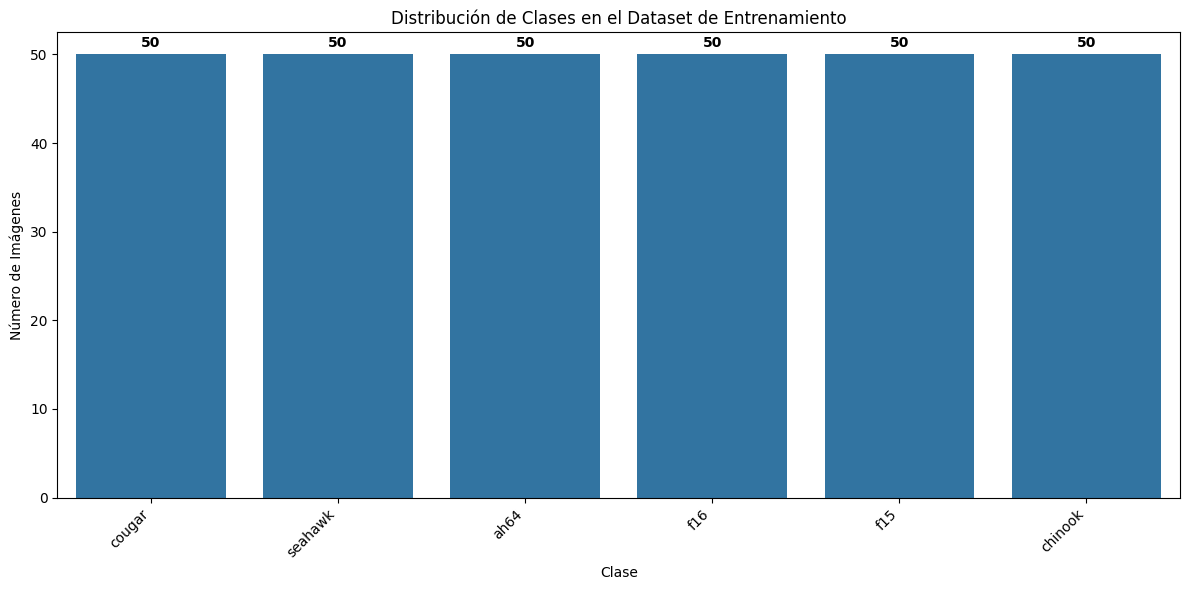

In [8]:
# Visualización del balance de clases
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values) # Store the axes object
plt.title('Distribución de Clases en el Dataset de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje x si hay muchas clases

# Mostrar los valores del numero de imagenes en cada una de las barras
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 0.5, str(v), color='black', ha='center', va='bottom', fontweight='bold')

plt.tight_layout() # Ajustar layout para que las etiquetas no se corten
plt.show()

In [9]:
# Determinar el número de clases y mapeos (índice <-> clase)
unique_classes = sorted(df_train['class'].unique())
num_classes = len(unique_classes)
class_to_idx = {cls_name: i for i, cls_name in enumerate(unique_classes)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}

print(f"\nNúmero total de clases únicas: {num_classes}")
print(f"Mapeo Clase a Índice: {class_to_idx}")
print(f"Mapeo Índice a Clase: {idx_to_class}")


Número total de clases únicas: 6
Mapeo Clase a Índice: {'ah64': 0, 'chinook': 1, 'cougar': 2, 'f15': 3, 'f16': 4, 'seahawk': 5}
Mapeo Índice a Clase: {0: 'ah64', 1: 'chinook', 2: 'cougar', 3: 'f15', 4: 'f16', 5: 'seahawk'}


In [10]:
# Inspeccionar dimensiones y formatos de algunas imágenes de muestra
print("\nInspeccionando propiedades de imágenes de muestra...")
sample_image_files = df_train['filename'].sample(min(10, len(df_train))).tolist() # Tomar una muestra
image_sizes = []
valid_images_count = 0

for img_file in sample_image_files:
    img_path = os.path.join(IMAGE_DIR_PATH, img_file)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size) # (width, height)
            # print(f"  {img_file}: {img.size}, Formato: {img.format}")
            valid_images_count += 1
    except FileNotFoundError:
            print(f"  Advertencia: Imagen no encontrada en la ruta esperada: {img_path}")
    except Exception as e:
        print(f"  Error al abrir o leer la imagen {img_file}: {e}")

print(f"Inspeccionadas {valid_images_count} de {len(sample_image_files)} imágenes de muestra.")

if image_sizes:
    # Sugerir un tamaño de imagen para redimensionamiento (basado en un tamaño común o promedio)
    # Para simplicidad didáctica, sugiero un tamaño común como 128x128 o 224x224
    # Si las imágenes varían mucho, un análisis más profundo sería necesario.
    # Vamos a ver las dimensiones más comunes si existen
    from collections import Counter
    size_counts = Counter(image_sizes)
    most_common_size = size_counts.most_common(1)
    if most_common_size:
        suggested_img_size = most_common_size[0][0] # (width, height)
        print(f"\nTamaño más común encontrado: {suggested_img_size}. Sugerencia de tamaño (Height, Width): ({suggested_img_size[1]}, {suggested_img_size[0]})")
    else:
            # Si no hay un tamaño común obvio en la muestra, sugerir un estándar
        suggested_img_size = (224, 224) # Tamaño común para CNNs (Width, Height)
        print(f"\nNo hay un tamaño común obvio en la muestra. Sugerencia de tamaño estándar para redimensionamiento (Height, Width): ({suggested_img_size[1]}, {suggested_img_size[0]})")

    # Guardar el tamaño sugerido (considerando que torch expects Height, Width)
    IMG_HEIGHT, IMG_WIDTH = suggested_img_size[1], suggested_img_size[0]

else:
    # Si no se pudo inspeccionar ninguna imagen, establecer un tamaño por defecto
    IMG_HEIGHT, IMG_WIDTH = 224, 224
    print(f"\nNo se pudieron inspeccionar imágenes válidas. Estableciendo tamaño por defecto para redimensionamiento (Height, Width): ({IMG_HEIGHT}, {IMG_WIDTH})")
#CAH!
IMG_HEIGHT, IMG_WIDTH = 255, 400
print(f"\nTamaño seleccionado para redimensionamiento: {IMG_HEIGHT}x{IMG_WIDTH} (Height x Width)")

# gc.collect()
# if device.type == 'cuda':
#     torch.cuda.empty_cache()

# Variables importantes definidas en este módulo para los siguientes:
# - device (torch.device)
# - BASE_DATA_PATH (str)
# - CSV_FILE_PATH (str)
# - IMAGE_DIR_PATH (str)
# - df_train (pandas.DataFrame)
# - num_classes (int)
# - class_to_idx (dict)
# - idx_to_class (dict)
# - IMG_HEIGHT, IMG_WIDTH (int)


Inspeccionando propiedades de imágenes de muestra...
Inspeccionadas 10 de 10 imágenes de muestra.

Tamaño más común encontrado: (1280, 720). Sugerencia de tamaño (Height, Width): (720, 1280)

Tamaño seleccionado para redimensionamiento: 255x400 (Height x Width)


## Preprocesamiento de Datos y Creación de DataLoaders

### Division de dataframes

In [11]:
#CAH! 
# Primero, dividir en train (70%) y temp (30%)
df_train_split, df_temp = train_test_split(
    df_train,
    test_size=0.3, # 30% para temp (val + test)
    random_state=42, # Para reproducibilidad
    stratify=df_train['class'] # Estratificar por clase para mantener el balance
)

# Luego, dividir temp (30%) en validación (15%) y prueba (15%)
# test_size=0.5 porque es 0.5 del 30% original, lo que da 15% del total
df_val_split, df_test_split = train_test_split(
    df_temp,
    test_size=0.5, # 50% de temp para test (10% del total)
    random_state=42, # Para reproducibilidad
    stratify=df_temp['class'] # Estratificar nuevamente
)



print(f"\nDimensiones de los DataFrames divididos:")
print(f"  Entrenamiento: {df_train_split.shape}")
print(f"  Validación: {df_val_split.shape}")
print(f"  Prueba: {df_test_split.shape}")


Dimensiones de los DataFrames divididos:
  Entrenamiento: (210, 8)
  Validación: (45, 8)
  Prueba: (45, 8)


In [12]:
# 3. Creación de un Dataset Personalizado
# PyTorch proporciona la clase `Dataset` que debemos heredar para crear la nuestra.
# Un Dataset personalizado requiere al menos los métodos __len__ y __getitem__.

class CustomImageDataset(torch.utils.data.Dataset):
    """Dataset personalizado para cargar imágenes desde un DataFrame y aplicar transformaciones."""

    def __init__(self, dataframe, img_dir, class_to_idx, transform=None):
        """
        Inicializa el Dataset.
        Args:
            dataframe (pandas.DataFrame): DataFrame con 'filename' y 'class'.
            img_dir (str): Directorio donde se encuentran todas las imágenes.
            class_to_idx (dict): Mapeo de nombres de clase a índices.
            transform (callable, optional): Transformaciones a aplicar.
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        # Mapear las etiquetas de clase de string a índice numérico
        self.label_indices = [self.class_to_idx[label] for label in self.img_labels['class']]

    def __len__(self):
        """Devuelve el número total de muestras en el dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Carga una muestra individual (imagen y etiqueta) por índice.
        Args:
            idx (int): Índice de la muestra.
        Returns:
            tuple: (imagen (Tensor), etiqueta (Tensor))
        """
        # Construir la ruta completa de la imagen
        img_name = self.img_labels.iloc[idx, 0] # Asumiendo 'filename' es la primera columna
        img_path = os.path.join(self.img_dir, img_name)

        try:
            # Abrir la imagen
            image = Image.open(img_path).convert('RGB') # Asegurar 3 canales RGB

            # Obtener la etiqueta y convertirla a tensor
            # label_name = self.img_labels.iloc[idx, 1] # Asumiendo 'class' es la segunda columna
            # label = torch.tensor(self.class_to_idx[label_name], dtype=torch.long)
            # Ya pre-calculamos los índices en __init__ para mayor eficiencia
            label = torch.tensor(self.label_indices[idx], dtype=torch.long)


            # Aplicar transformaciones si existen
            if self.transform:
                image = self.transform(image)

            return image, label

        except FileNotFoundError:
             print(f"Advertencia: Imagen no encontrada, saltando: {img_path}")
             # Devolver None o manejar de otra forma. Para simplificar, en un caso real
             # podrías querer limpiar el DataFrame antes de crear el dataset.
             # Aquí, devolver None podría causar problemas en el DataLoader,
             # una mejor práctica es asegurar que todas las rutas sean válidas antes.
             # Asumiremos por ahora que las rutas son válidas o que el error es raro.
             # Si ocurre con frecuencia, considera filtrar el DataFrame inicialmente.
             return None, None # Esto requiere manejo en el DataLoader o bucle de entrenamiento.
                             # Una alternativa mejor es simplemente no incluir esta muestra en el dataset.
                             # Pero para este ejemplo, asumimos que el DataFrame ya es válido.

        except Exception as e:
            print(f"Error al cargar o transformar la imagen {img_path}: {e}, saltando.")
            return None, None


print("Clase CustomImageDataset definida.")

Clase CustomImageDataset definida.


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

#CAH!
BATCH_SIZE = 32 # Puedes empezar con 32 o 64 y reducir si da 'CUDA out of memory'

# Solo convierte a tensor (0–255 → 0–1), sin normalizar aún
base_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])


dataset = CustomImageDataset(
    dataframe=df_train,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=base_transform
)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# Acumular sumas y sumas de cuadrados
n_images = 0
sum_channels = torch.zeros(3)
sum_sq_channels = torch.zeros(3)

for imgs, _ in loader:
    n_batch = imgs.size(0)
    # imgs: [batch, 3, H, W]
    imgs = imgs.view(n_batch, 3, -1)  # [batch, 3, H*W]
    sum_channels += imgs.mean(dim=[0,2]) * n_batch
    sum_sq_channels += (imgs ** 2).mean(dim=[0,2]) * n_batch
    n_images += n_batch

# Media por canal
mean = sum_channels / n_images
# Varianza y luego std
var  = sum_sq_channels / n_images - mean**2
std  = torch.sqrt(var)

mean_list = mean.tolist()
std_list = std.tolist()

print("mean =", mean_list)
print("std  =", std_list)


mean = [0.528589129447937, 0.5788546204566956, 0.6231197714805603]
std  = [0.24197205901145935, 0.24344542622566223, 0.27202919125556946]


In [14]:
# 2. Definición de Transformaciones de Preprocesamiento Estándar
# Estas transformaciones se aplicarán a los conjuntos de validación y prueba.
# Para entrenamiento, añadiremos Aumento de Datos en el MÓDULO 3.

# Definir las transformaciones básicas: redimensionar, convertir a tensor, normalizar.
# La normalización utiliza la media y desviación estándar de ImageNet, un estándar común.
# Para mayor precisión, deberías calcular la media/std de TU dataset de entrenamiento.
standard_transforms = transforms.Compose([
    # Redimensionar la imagen al tamaño objetivo. Bilinear es un buen interpolador por defecto.
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    # Convertir la imagen PIL a un Tensor de PyTorch (HWC -> CHW, 0-255 -> 0-1)
    transforms.ToTensor(),
    # Normalizar el tensor: canal = (canal - media) / std
    transforms.Normalize(mean=mean_list, std=std_list)
])

print("\nTransformaciones de preprocesamiento estándar definidas.")


Transformaciones de preprocesamiento estándar definidas.


### Instanciación de Datasets

In [15]:
# 4. Instanciación de Datasets
# Creamos instancias de nuestro Dataset para cada conjunto (train, val, test).
# Nota: train_dataset usará standard_transforms por ahora. Se actualizará en MÓDULO 3.
train_dataset = CustomImageDataset(
    dataframe=df_train_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Usamos standard por ahora, M3 lo cambiará para train
)

val_dataset = CustomImageDataset(
    dataframe=df_val_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Validación usa transformaciones estándar (sin aumento)
)

test_dataset = CustomImageDataset(
    dataframe=df_test_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Prueba usa transformaciones estándar (sin aumento)
)

print(f"\nDatasets instanciados:")
print(f"  Entrenamiento: {len(train_dataset)} muestras")
print(f"  Validación: {len(val_dataset)} muestras")
print(f"  Prueba: {len(test_dataset)} muestras")



Datasets instanciados:
  Entrenamiento: 210 muestras
  Validación: 45 muestras
  Prueba: 45 muestras


### Batch Size

In [16]:
# Definir el tamaño del lote (Batch Size). CRUCIAL para el uso de VRAM.
# Un tamaño más grande puede acelerar el entrenamiento pero consume más VRAM.
# Ajusta este valor según la memoria de tu GPU (8GB es limitado, empieza con 32 o 64).

# num_workers: Número de subprocesos para cargar datos. 0 significa que la carga es en el hilo principal.
# Para un notebook simple o depuración, 0 es aceptable. Para rendimiento en entrenamiento, usar > 0 es mejor,
# pero puede causar problemas en algunos entornos Jupyter (especialmente en Windows).
# Empieza con 0 y aumenta si necesitas más velocidad de carga.
NUM_WORKERS = 0 # Mantener en 0 para simplicidad en notebook

print(f"\nConfiguración de DataLoaders:")
print(f"  Tamaño del lote (BATCH_SIZE): {BATCH_SIZE}")
print(f"  Número de workers (NUM_WORKERS): {NUM_WORKERS}")


Configuración de DataLoaders:
  Tamaño del lote (BATCH_SIZE): 32
  Número de workers (NUM_WORKERS): 0


### Creación de DataLoaders

In [17]:
# 5. Creación de DataLoaders
# Los DataLoaders permiten iterar sobre el dataset en lotes y manejar el multi-threading para la carga.
print(f'Dispositivo seleccionado:{device.type}')
# Instanciar los DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Importante para entrenamiento: barajar los datos en cada época
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False # Copia datos a la memoria fija del host, útil para GPU
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la validación
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la prueba
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print("\nDataLoaders creados: train_loader, val_loader, test_loader")

Dispositivo seleccionado:cuda

DataLoaders creados: train_loader, val_loader, test_loader


In [18]:
# 6. Verificación Rápida de un Lote
# Tomar un lote de ejemplo para verificar las dimensiones y el dispositivo
try:
    # Obtener un iterador para el DataLoader
    data_iter = iter(train_loader)
    # Obtener el primer lote
    images, labels = next(data_iter)

    print(f"\nVerificación de un lote del train_loader:")
    print(f"  Dimensiones de las imágenes en el lote: {images.shape}") # Esperado: [BATCH_SIZE, Canales, Altura, Ancho]
    print(f"  Tipo de dato de las imágenes: {images.dtype}")
    print(f"  Dimensiones de las etiquetas en el lote: {labels.shape}") # Esperado: [BATCH_SIZE]
    print(f"  Tipo de dato de las etiquetas: {labels.dtype}")
    print(f"  Valores de las primeras 10 etiquetas: {labels[:10]}")
    print(f"  Rango de valores de píxeles (normalizados): min={images.min().item():.4f}, max={images.max().item():.4f}")

    # Mover un lote al dispositivo seleccionado (GPU si es posible) para probar
    images = images.to(device)
    labels = labels.to(device)
    print(f"  Dispositivo de las imágenes después de mover: {images.device}")
    print(f"  Dispositivo de las etiquetas después de mover: {labels.device}")

    # Liberar tensores de prueba para no consumir VRAM innecesariamente
    del images, labels
    # Limpiar caché de VRAM
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Lote de prueba cargado y verificado. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar cargar un lote de prueba: {e}")
    print("Asegúrate de que las rutas y el DataFrame son correctos y que hay imágenes válidas.")


# Limpieza de memoria opcional
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Variables importantes definidas en este módulo para los siguientes:
# - df_train_split, df_val_split, df_test_split (pandas.DataFrame) - Las divisiones
# - standard_transforms (torchvision.transforms.Compose) - Transformaciones sin aumento
# - train_dataset, val_dataset, test_dataset (CustomImageDataset) - Los Datasets
# - train_loader, val_loader, test_loader (torch.utils.data.DataLoader) - Los DataLoaders
# - BATCH_SIZE (int)
# - NUM_WORKERS (int)


Verificación de un lote del train_loader:
  Dimensiones de las imágenes en el lote: torch.Size([32, 3, 255, 400])
  Tipo de dato de las imágenes: torch.float32
  Dimensiones de las etiquetas en el lote: torch.Size([32])
  Tipo de dato de las etiquetas: torch.int64
  Valores de las primeras 10 etiquetas: tensor([2, 1, 0, 2, 5, 4, 4, 0, 0, 0])
  Rango de valores de píxeles (normalizados): min=-2.3778, max=1.9482
  Dispositivo de las imágenes después de mover: cuda:0
  Dispositivo de las etiquetas después de mover: cuda:0
Lote de prueba cargado y verificado. Tensores liberados.


### Técnicas de Aumento de Datos (Data Augmentation)

In [19]:
# MÓDULO 3: Técnicas de Aumento de Datos (Data Augmentation)
# Asegurarse de que las variables del MÓDULO 1 y MÓDULO 2 estén disponibles
# df_train_split (o la estructura para crear el dataset), IMAGE_DIR_PATH, class_to_idx
# IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, NUM_WORKERS, CustomImageDataset
# standard_transforms (para comparar o asegurar consistencia en preproc base)
if 'train_dataset' not in locals(): # Verificamos una variable clave del M2
     print("Error: Variables del MÓDULO 2 no encontradas. Asegúrate de ejecutar el MÓDULO 2 primero.")
     raise RuntimeError("Faltan variables del MÓDULO 2. Ejecuta el MÓDULO 2.")

print(f"\nUsando tamaño de imagen para augmentation: ({IMG_HEIGHT}x{IMG_WIDTH})")

# 1. Definición de Transformaciones con Aumento de Datos para Entrenamiento
# Estas transformaciones incluyen el preprocesamiento estándar MÁS técnicas de aumento.
# Es crucial que las transformaciones finales resulten en tensores del mismo tamaño (C, H, W)
# que las imágenes preprocesadas estándar.

# Puedes experimentar con diferentes transformaciones y sus parámetros.
# Aquí se incluyen ejemplos comunes:
train_transforms = transforms.Compose([
    # Aumento: Recorta aleatoriamente y redimensiona a IMG_HEIGHT x IMG_WIDTH.
    # Scale es el rango del tamaño del recorte respecto al tamaño original.
    # Ratio es el rango de la relación de aspecto del recorte.
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    # Aumento: Voltea horizontalmente la imagen con una probabilidad p=0.5.
    transforms.RandomHorizontalFlip(p=0.5),
    # Aumento: Ajustes aleatorios de brillo, contraste, saturación y matiz.
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    # Aumento: Rotación aleatoria. Degrees es el rango de ángulos.
    transforms.RandomRotation(degrees=10),
    # Convertir a tensor (como en standard_transforms)
    transforms.ToTensor(),
    # Normalizar (como en standard_transforms) - ¡Esto debe ir después de ToTensor!
    transforms.Normalize(mean=mean_list, std=std_list)
    # Puedes añadir más: RandomVerticalFlip, RandomPerspective, RandomAffine, Grayscale, etc.
])

print("\nTransformaciones con aumento de datos para entrenamiento definidas.")

# Las transformaciones para validación y prueba siguen siendo las estándar sin aumento
# (ya definidas como standard_transforms en MÓDULO 2).


# 2. Re-instanciar el Dataset de Entrenamiento con las Nuevas Transformaciones
# Usamos la misma clase CustomImageDataset definida en el MÓDULO 2.
# Solo cambiamos el argumento 'transform'.
train_dataset = CustomImageDataset(
    dataframe=df_train_split, # Usamos el mismo split de entrenamiento del MÓDULO 2
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=train_transforms # ¡Ahora usamos las transformaciones con aumento!
)

print(f"\nDataset de entrenamiento actualizado para usar aumento de datos: {len(train_dataset)} muestras.")
# Los datasets de validación y prueba (val_dataset, test_dataset) NO se modifican.

# 3. Re-crear el DataLoader de Entrenamiento
# Re-creamos el DataLoader de entrenamiento usando el dataset actualizado.
# Mantenemos la misma configuración de BATCH_SIZE y NUM_WORKERS.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Seguir barajando el conjunto de entrenamiento
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader de entrenamiento re-creado con BATCH_SIZE={BATCH_SIZE} y NUM_WORKERS={NUM_WORKERS}.")
# Los DataLoaders de validación y prueba (val_loader, test_loader) NO se modifican.


Usando tamaño de imagen para augmentation: (255x400)

Transformaciones con aumento de datos para entrenamiento definidas.

Dataset de entrenamiento actualizado para usar aumento de datos: 210 muestras.
DataLoader de entrenamiento re-creado con BATCH_SIZE=32 y NUM_WORKERS=0.


### Visualización Opcional del Efecto del Aumento de Datos


Visualizando un lote de imágenes con aumento de datos (muestra)...


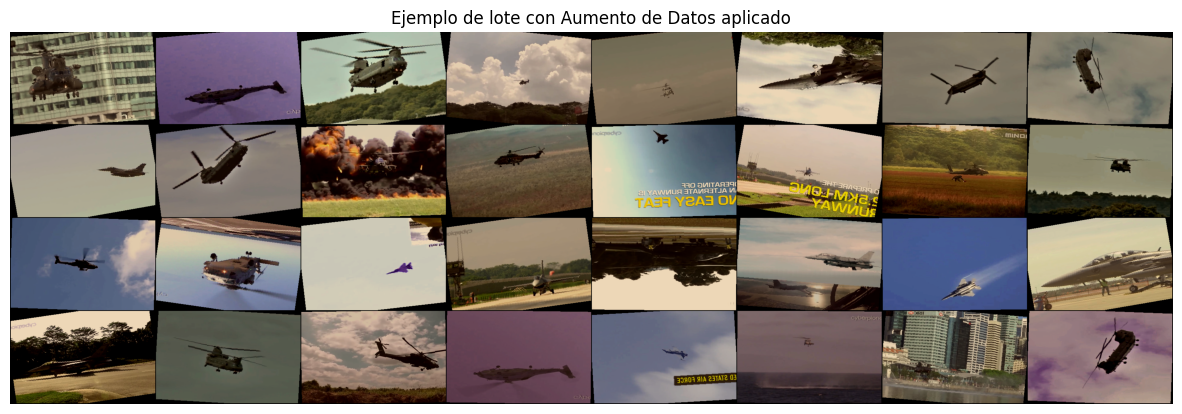

Etiquetas para el lote mostrado: [1, 5, 1, 2, 5, 3, 1, 1, 4, 1, 0, 2, 4, 4, 0, 1, 0, 5, 3, 4, 0, 4, 3, 3, 4, 1, 0, 5, 4, 5, 1, 1]
Visualización completada. Tensores liberados.


In [20]:

# 4. Visualización Opcional del Efecto del Aumento de Datos
# Para entender visualmente qué hacen las transformaciones de aumento.
print("\nVisualizando un lote de imágenes con aumento de datos (muestra)...")
try:
    # Tomar un lote de ejemplo del NUEVO train_loader
    images, labels = next(iter(train_loader))

    # Las imágenes ya están normalizadas. Para visualizarlas correctamente,
    # necesitamos "de-normalizarlas" (aplicar la inversa de la normalización).
    # Media y Std usados para normalización (ImageNet)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    # De-normalizar: imagen = imagen * std + media
    # Clonar para no modificar el tensor original que podríamos usar después
    images_display = images * std + mean
    images_display = torch.clamp(images_display, 0, 1) # Asegurar que los valores estén en [0, 1]

    # Usar make_grid para crear una cuadrícula de imágenes
    grid = torchvision.utils.make_grid(images_display, nrow=8, padding=2) # nrow: imágenes por fila

    # Convertir el tensor de la cuadrícula a formato (H, W, C) para matplotlib
    plt.figure(figsize=(15, (BATCH_SIZE // 8) * 2)) # Ajusta el tamaño de la figura
    plt.imshow(grid.permute(1, 2, 0)) # Permuta las dimensiones para (H, W, C)
    plt.title("Ejemplo de lote con Aumento de Datos aplicado")
    plt.axis('off') # Ocultar ejes
    plt.show()

    # Mostrar las etiquetas de este lote
    print(f"Etiquetas para el lote mostrado: {labels.tolist()}")
    # Opcionalmente, mapear a nombres de clase si quieres:
    # label_names = [idx_to_class[l.item()] for l in labels]
    # print(f"Nombres de clase: {label_names}")


    # Liberar tensores de visualización
    del images, labels, images_display, grid, mean, std
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Visualización completada. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar visualizar un lote con aumento de datos: {e}")
    print("Asegúrate de que el DataLoader funciona y matplotlib/torchvision están correctamente instalados.")


# Limpieza de memoria opcional
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Variables importantes actualizadas o usadas en este módulo para los siguientes:
# - train_transforms (torchvision.transforms.Compose) - Nuevas transformaciones con aumento
# - train_dataset (CustomImageDataset) - Actualizado con train_transforms
# - train_loader (torch.utils.data.DataLoader) - Re-creado con el nuevo train_dataset
# - val_loader, test_loader (se mantienen del MÓDULO 2, NO usan aumento)

## Definición de la Arquitectura CNN (Modular y Parametrizable)

In [21]:
# MÓDULO 4: Definición de la Arquitectura CNN (Modular y Parametrizable)

# Asegurarse de que las variables del MÓDULO 1 estén disponibles
# device, num_classes
if 'device' not in locals() or 'num_classes' not in locals():
     print("Error: Variables del MÓDULO 1 (device, num_classes) no encontradas. Asegúrate de ejecutar el MÓDULO 1 primero.")
     raise RuntimeError("Faltan variables del MÓDULO 1. Ejecuta el MÓDULO 1.")

print(f"\nDispositivo para el modelo: {device}")
print(f"Número de clases para la capa de salida: {num_classes}")
# IMG_HEIGHT, IMG_WIDTH también son relevantes, aunque la arquitectura simple
# puede ser un poco agnóstica al tamaño exacto antes de las capas lineales.

# 1. Definición de la Clase del Modelo CNN
# Heredamos de nn.Module, la clase base para todos los módulos de redes neuronales en PyTorch.
class SimpleCNN(nn.Module):
    """
    Una arquitectura CNN simple y didáctica para clasificación de imágenes.
    Consiste en capas convolucionales seguidas de capas totalmente conectadas.
    """
    def __init__(self, num_classes):
        """
        Inicializa el modelo CNN.
        Args:
            num_classes (int): El número de clases de salida para la capa final.
        """
        super(SimpleCNN, self).__init__() # Llamar al constructor de la clase base

        # Definir las capas convolucionales y de pooling
        # Conv2d(canales_entrada, canales_salida, tamaño_kernel, stride, padding)
        # MaxPool2d(tamaño_kernel, stride, padding)

        # Primera capa convolucional
        # Entrada: 3 canales (RGB), Tamaño: IMG_HEIGHT x IMG_WIDTH (después de M2/M3)
        # Salida: 16 canales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # nn.BatchNorm2d ayuda a estabilizar y acelerar el entrenamiento
        self.bn1 = nn.BatchNorm2d(16)
        # Max Pooling: reduce las dimensiones espaciales
        # Tamaño de salida después de conv1 y pool1: (H/2) x (W/2) con 16 canales
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        # Entrada: 16 canales (salida de conv1/pool1)
        # Salida: 32 canales
        # Tamaño de salida después de conv2 y pool2: ((H/2)/2) x ((W/2)/2) = (H/4) x (W/4) con 32 canales
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Tercera capa convolucional (Opcional, para modelos un poco más profundos)
        # Entrada: 32 canales (salida de conv2/pool2)
        # Salida: 64 canales
        # Tamaño de salida después de conv3 y pool3: ((H/4)/2) x ((W/4)/2) = (H/8) x (W/8) con 64 canales
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Calcular el tamaño de la entrada a la primera capa lineal (Flatten)
        # Esto depende del tamaño de la imagen de entrada y de las operaciones convolucionales/pooling.
        # Es más seguro calcularlo dinámicamente o pre-calcularlo.
        # Para un tamaño de entrada (H, W) y 3 capas con kernel_size=3, stride=1, padding=1, y pool_size=2, stride=2:
        # Tamaño de salida después de 3 pools es aproximadamente (H/8) x (W/8)
        # El número de canales de salida del último conv es 64.
        # La entrada a la capa lineal será 64 * (H/8) * (W/8)
        # Vamos a usar un tamaño fijo basado en un tamaño común (ej. 224x224 -> 224/8 = 28).
        # Si tu IMG_HEIGHT/IMG_WIDTH es diferente, deberás ajustar esta dimensión de entrada lineal.
        # O podrías pasar las dimensiones de entrada al __init__ y calcularlo.
        # Para ser robustos, vamos a *asumir* un tamaño común después de pooling.
        # Una forma más robusta sería pasar un tensor de prueba a través de las capas conv/pool
        # en __init__ para determinar el tamaño correcto antes de definir las capas lineales.

        # Ejemplo con 224x224 -> 28x28 después de 3 pools
        # Si usas 128x128 -> 128/8 = 16. La entrada lineal sería 64 * 16 * 16
        # Si usas 64x64 -> 64/8 = 8. La entrada lineal sería 64 * 8 * 8
        # ... necesitamos que esto sea correcto para el tamaño elegido (IMG_HEIGHT, IMG_WIDTH).
        # Calculémoslo basado en el tamaño efectivo después de los pools:
        # Tamaño después de 3 pools = floor(floor(floor(IMG_HEIGHT/2)/2)/2) x floor(floor(floor(IMG_WIDTH/2)/2)/2)
        # Simplified: IMG_HEIGHT // (2**3), IMG_WIDTH // (2**3)
        final_h = IMG_HEIGHT // 8
        final_w = IMG_WIDTH // 8
        linear_input_features = 64 * final_h * final_w # Canales_ultima_conv * Altura_final * Ancho_final
        print(f"Tamaño de entrada calculado para la capa lineal: {linear_input_features}")
        # Asegurarse de que final_h y final_w sean al menos 1
        if final_h < 1 or final_w < 1:
             raise ValueError(f"El tamaño de imagen ({IMG_HEIGHT}x{IMG_WIDTH}) es demasiado pequeño para 3 capas de pooling.")

        # Definir las capas totalmente conectadas (Fully Connected - FC)
        # La primera capa FC toma la salida aplanada de las capas convolucionales.
        self.fc1 = nn.Linear(in_features=linear_input_features, out_features=128)
        self.bn4 = nn.BatchNorm1d(128) # BatchNorm después de la lineal y antes de la activación
        # Capa de Dropout para regularización (ayuda a prevenir el sobreajuste)
        self.dropout = nn.Dropout(p=0.5)
        # La capa final FC tiene el número de neuronas igual al número de clases.
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)


    def forward(self, x):
        """
        Define el pase hacia adelante (forward pass) del modelo.
        Define cómo los datos fluyen a través de las capas.
        """
        # Aplicar capas convolucionales, BatchNorm, activación ReLU y Pooling
        # (Canales_entrada, H, W) -> (Canales_salida_conv1, H/2, W/2)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # (Canales_salida_conv1, H/2, W/2) -> (Canales_salida_conv2, H/4, W/4)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # (Canales_salida_conv2, H/4, W/4) -> (Canales_salida_conv3, H/8, W/8)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Aplanar la salida de las capas convolucionales para pasarla a las capas FC
        # El "-1" en view() infiere automáticamente el tamaño del lote
        # x.size(0) es el tamaño del lote
        # x.view(x.size(0), -1) aplana cada imagen en el lote en un vector 1D
        # La dimensión aplanada es linear_input_features (calculada en __init__)
        x = x.view(x.size(0), -1) # Equivalentemente: x = torch.flatten(x, 1)

        # Aplicar capas totalmente conectadas con activación ReLU y Dropout
        # -> (Tamaño_lote, 128)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        # -> (Tamaño_lote, num_classes) - Salida final (logits antes de softmax)
        x = self.fc2(x)

        return x # La salida son los logits, no las probabilidades (la función de pérdida maneja softmax)


# 2. Instanciación del Modelo
# Creamos una instancia de nuestra clase CNNModel.
# Le pasamos el número de clases determinado en el MÓDULO 1.
model = SimpleCNN(num_classes=num_classes)

print("\nInstancia del modelo SimpleCNN creada.")

# 3. Mover el Modelo al Dispositivo Seleccionado (GPU si es posible)
# ¡Esto es CRUCIAL! Mueve todos los parámetros y búferes del modelo a la GPU VRAM.
model.to(device)

print(f"Modelo movido al dispositivo: {device}")

# 4. (Opcional) Mostrar la Estructura del Modelo
# Puedes imprimir el objeto modelo para ver una representación textual de sus capas.
print("\nEstructura del modelo:")
print(model)

# Puedes usar la librería 'torchsummary' para un resumen más detallado si está instalada:
# !pip install torchsummary # Descomenta y ejecuta si no la tienes
try:    
    # summary(model, input_size=(Canales, Altura, Ancho))
    # Necesitas pasar el tamaño de entrada esperado por la primera capa Conv2d
    print("\nResumen del modelo (con torchsummary):")
    summary(model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))
except ImportError:
    print("\nInstala torchsummary (pip install torchsummary) para ver un resumen detallado del modelo.")
except Exception as e:
    print(f"\nError al generar resumen con torchsummary: {e}")
    print("Asegúrate de que el tamaño de entrada (3, IMG_HEIGHT, IMG_WIDTH) es correcto.")


# --- Notas sobre Transfer Learning (Alternativa más común en la práctica) ---
# print("\n--- Notas sobre Transfer Learning ---")
# print("En la práctica, para tareas de clasificación de imágenes, rara vez se entrena una CNN desde cero.")
# print("Una técnica mucho más efectiva es usar Transfer Learning, empezando con un modelo pre-entrenado")
# print("en un dataset grande como ImageNet (ej. ResNet, VGG, EfficientNet) y ajustándolo a tu tarea.")
# print("Esto aprovecha las características visuales genéricas aprendidas por el modelo pre-entrenado.")
# print("\nPara usar un modelo pre-entrenado de torchvision:")
# print("1. Carga el modelo pre-entrenado:")
# print("   # from torchvision import models")
# print("   # model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)")
# print("2. Reemplaza la capa final (clasificador) para que coincida con el número de tus clases:")
# print("   # num_ftrs = model_ft.fc.in_features")
# print("   # model_ft.fc = nn.Linear(num_ftrs, num_classes)")
# print("   # Para ResNets, la capa final es 'fc'")
# print("   # Para VGGs, es la última capa lineal en 'classifier'")
# print("3. Opcionalmente, congela los pesos de las capas iniciales si solo quieres entrenar la capa final:")
# print("   # for param in model_ft.parameters():")
# print("   #     param.requires_grad = False")
# print("   # Solo se entrenarán los parámetros donde requires_grad=True (la capa final)")
# print("4. Mueve el modelo al dispositivo: model_ft = model_ft.to(device)")
# print("Usar Transfer Learning suele dar mejores resultados con menos datos de entrenamiento y tiempo.")
# print("La arquitectura SimpleCNN definida arriba es didáctica, pero Transfer Learning es el camino a seguir en la mayoría de los proyectos reales.")
# print("Considera reemplazar SimpleCNN con un modelo pre-entrenado para tu implementación final.")


# Limpieza de memoria opcional

gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Variable importante definida en este módulo para los siguientes:
# - model (torch.nn.Module) - La instancia del modelo lista en el dispositivo


Dispositivo para el modelo: cuda
Número de clases para la capa de salida: 6
Tamaño de entrada calculado para la capa lineal: 99200

Instancia del modelo SimpleCNN creada.
Modelo movido al dispositivo: cuda

Estructura del modelo:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (

## Entrenamiento para Optimización (Objective Function)

In [22]:
# MÓDULO 5: Definición de la Función de Entrenamiento para Optimización (Objective Function)
# Asegurarse de que las variables de módulos anteriores estén disponibles
# device, train_loader, val_loader, num_classes, class_to_idx
# ¡Importante! La *definición* de la clase del modelo (SimpleCNN) debe estar disponible desde el MÓDULO 4.
if 'train_loader' not in locals() or 'val_loader' not in locals() or 'device' not in locals() or 'num_classes' not in locals() or 'SimpleCNN' not in locals():
     print("Error: Variables o clase SimpleCNN de módulos anteriores no encontradas.")
     print("Asegúrate de ejecutar los MÓDULOS 1, 2 (incluyendo la recreación en M3) y 4 primero.")
     raise RuntimeError("Faltan componentes necesarios para definir la función objetivo.")

print(f"\nComponentes disponibles para la función objetivo:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Clase del modelo: {SimpleCNN.__name__}") # Verificamos que la clase SimpleCNN está definida

# 1. Definición de la Función Objetivo para Optuna
# Esta función ejecutará un ciclo completo de entrenamiento y validación para un conjunto de hiperparámetros sugeridos por Optuna.

def objective(trial, train_loader, val_loader, device, num_classes, checkpoint_dir='./optuna_checkpoints'):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.
    Entrena y valida un modelo con los hiperparámetros sugeridos por 'trial'.

    Args:
        trial (optuna.Trial): Objeto Trial proporcionado por Optuna para sugerir HPs y reportar métricas.
        train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
        val_loader (DataLoader): DataLoader para el conjunto de validación.
        device (torch.device): Dispositivo (CPU/GPU) para entrenar.
        num_classes (int): Número de clases de salida.
        checkpoint_dir (str): Directorio base para guardar checkpoints de las pruebas.

    Returns:
        float: La métrica de validación a maximizar (por ejemplo, precisión de validación).
              Optuna intenta maximizar/minimizar este valor.
    """
    print(f"\n--- Iniciando Prueba Optuna #{trial.number} ---")

    # --- Sugerir Hiperparámetros ---
    # Optuna llama a trial.suggest_... para obtener un valor para un hiperparámetro.
    # El nombre (ej. 'learning_rate') identifica el hiperparámetro.
    # Los argumentos siguientes definen el rango o las opciones a explorar.

    # Tasa de aprendizaje (escala logarítmica es común para LR)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Factor de weight decay (regularización L2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
#CAH!
    # Tasa de dropout
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.8) # Rango entre 10% y 60%

    # Elección del optimizador (opcional, más complejo)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    momentum = trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else None

    print(f"  Hiperparámetros sugeridos:")
    print(f"    Learning Rate: {lr:.6f}")
    print(f"    Weight Decay: {weight_decay:.6f}")
    print(f"    Dropout Rate: {dropout_rate:.2f}")
    if optimizer_name == "SGD": print(f"    Optimizer: {optimizer_name}, Momentum: {momentum:.2f}")
    else: print(f"    Optimizer: {optimizer_name}")


    # --- Configurar Modelo, Función de Pérdida y Optimizador ---
    # Re-instanciar el modelo para cada prueba para asegurar un estado limpio
    # Necesitamos que la definición de SimpleCNN esté disponible (definida en MÓDULO 4)
    model = SimpleCNN(num_classes=num_classes) # Re-instanciar
    # Ajustar dropout en el modelo si lo estamos tunenado (requiere modificar SimpleCNN si no era param)
    # Si SimpleCNN no tenía dropout_rate como argumento, deberías modificar su __init__
    # o simplemente tunear HPs que ya son parámetros del modelo o optimizador.
    # Asumimos que SimpleCNN usa un dropout fijo por ahora o lo modificamos.
    # Para tunear el dropout, SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate)
    # y dentro de SimpleCNN.__init__ self.dropout = nn.Dropout(p=dropout_rate)

    # Para el ejemplo simple actual de SimpleCNN con dropout fijo de 0.5:
    # Tunear la tasa de dropout requeriría pasarla al constructor de SimpleCNN
    # o modificar el módulo de dropout después de instanciar.
    # Vamos a modificar la instancia del modelo *después* de crearla para tunear el dropout fijo de 0.5
    # Esto requiere saber exactamente qué capa es el dropout.
    # Si tu SimpleCNN tiene un nn.Dropout con p=0.5:
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout_rate # Ajusta la tasa de dropout sugerida por Optuna
            print(f"    Ajustada tasa de dropout en el modelo a: {dropout_rate:.2f}")


    model.to(device) # Mover el modelo al dispositivo

    criterion = nn.CrossEntropyLoss() # Función de pérdida es usualmente fija

    # Configurar el optimizador con los HPs sugeridos
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Configurar el scheduler (opcional, puede ayudar pero añade otra capa de HPs a tunear si no es fijo)
    # Mantendremos un scheduler simple con parámetros fijos para no añadir más complejidad de tuning
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(ptimizer, mode='max', factor=0.1, patience=5)
    #CAH!
    # --- Bucle de Entrenamiento y Validación (similar a MÓDULO 5 original) ---
    num_epochs_trial = 100 # 30 Número de épocas para cada prueba. Puede ser menor que el final.
                         # O puedes tunearlo con early stopping y patience.
    patience = 50 # 7 Paciencia para Early Stopping DENTRO de cada prueba de Optuna

    best_val_accuracy = -1.0
    epochs_since_last_improvement = 0
    best_val_loss = float('inf') # Inicializar la mejor pérdida de validación

    # Para guardar el estado del mejor modelo *de esta prueba*
    best_model_state = None
    best_optimizer_state = None

    #print(f"  Comenzando entrenamiento para Prueba #{trial.number} por hasta {num_epochs_trial} épocas...")


    for epoch in range(num_epochs_trial):
        # start_time_epoch = time.time() # Puedes medir tiempo por época si quieres
        print(f"\nTrial {trial.number} Época {epoch+1}/{num_epochs_trial}:")
        # Entrenamiento
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train_preds += labels.size(0)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct_train_preds / total_train_preds
        #print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')

        # Validación
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val_preds += labels.size(0)
                correct_val_preds += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct_val_preds / total_val_preds

        print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
        print(f'epoch_val_loss  : {epoch_val_loss:.4f}, epoch_val_accuracy  : {epoch_val_accuracy:.2f}%')

        # Step del Scheduler
        #scheduler.step(epoch_val_accuracy)

        # Checkpointing (dentro del trial) y Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_since_last_improvement = 0
            # Guardar el estado del mejor modelo *de esta prueba*
            best_model_state = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            print(f"    Mejora en Prueba #{trial.number}, Época {epoch+1}. loss: {best_val_loss} Precisión: {epoch_val_accuracy:.2f}%") # Opcional, puede ser ruidoso

        else:
            epochs_since_last_improvement += 1
            print(f"    Sin mejora en Prueba #{trial.number}, Época {epoch+1}. Paciencia: {epochs_since_last_improvement}/{patience}") # Opcional

        # Checkpointing (dentro del trial) y Early Stopping
        # if epoch_val_accuracy > best_val_accuracy:
        #     best_val_accuracy = epoch_val_accuracy
        #     epochs_since_last_improvement = 0
        #     # Guardar el estado del mejor modelo *de esta prueba*
        #     best_model_state = copy.deepcopy(model.state_dict())
        #     best_optimizer_state = copy.deepcopy(optimizer.state_dict())
        #     print(f"    Mejora en Prueba #{trial.number}, Época {epoch+1}. Precisión: {best_val_accuracy:.2f}%") # Opcional, puede ser ruidoso

        # else:
        #     epochs_since_last_improvement += 1
        #     print(f"    Sin mejora en Prueba #{trial.number}, Época {epoch+1}. Paciencia: {epochs_since_last_improvement}/{patience}") # Opcional

        # Reportar métrica intermedia a Optuna (puedes reportar pérdida, precisión, etc.)
        # Esto permite a Optuna podar (detener) pruebas que no parecen prometedoras.
        # Optuna espera la métrica que está optimizando.
        trial.report(epoch_val_loss, epoch)

        # Verificar si la prueba debe ser podada por Optuna
        if trial.should_prune():
            print(f"  Prueba #{trial.number} podada en la Época {epoch+1} (loss {epoch_val_loss} precisión {epoch_val_accuracy:.2f}%).")
            raise optuna.exceptions.TrialPruned()

        # Early Stopping Check (basado en la paciencia dentro de la prueba)
        if epochs_since_last_improvement >= patience:
            print(f"  Early stopping para Prueba #{trial.number}. No hubo mejora en {patience} épocas.")
            break # Salir del bucle de entrenamiento de la prueba

        # Limpieza de VRAM en cada época del trial
        if device.type == 'cuda':
             torch.cuda.empty_cache()
             # Opcional: monitorizar VRAM aquí si es necesario


    print(f"--- Prueba Optuna #{trial.number} Finalizada. Mejor loss de Validación: {best_val_loss} ---")

    # Opcional: Guardar el mejor checkpoint *de esta prueba* en un archivo.
    # Esto es útil si quieres re-cargar el mejor modelo de una prueba específica después.
    # Si solo te interesa el mejor modelo *general* del estudio, lo guardaremos al final del MÓDULO 6.
    trial_checkpoint_path = os.path.join(checkpoint_dir, f'trial_{trial.number}_best_checkpoint.pth')
    torch.save({
         'model_state_dict': best_model_state,
         'optimizer_state_dict': best_optimizer_state, # Opcional, no siempre necesario después del tuning
         'best_val_loss': best_val_loss,
         #'best_val_accuracy': best_val_accuracy,
         'hps': trial.params
    }, trial_checkpoint_path)
    print(f"  Mejor checkpoint de Prueba #{trial.number} guardado en: {trial_checkpoint_path}")


    # Limpiar memoria después de cada trial
    del model, optimizer, criterion # scheduler es más ligero
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de la limpieza del trial: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    # La función objetivo DEBE retornar el valor a optimizar
    return best_val_loss # Optuna intentará maximizar este valor


print("\nFunción 'objective' definida. Lista para ser utilizada por Optuna.")

# Variables importantes definidas en este módulo para los siguientes:
# - objective (function) - La función que Optuna llamará
# - train_loader, val_loader, device, num_classes (pasados a la función objective)
# - SimpleCNN (clase modelo, usada DENTRO de la función objective)


Componentes disponibles para la función objetivo:
  Dispositivo: cuda
  DataLoaders: train_loader (210 muestras), val_loader (45 muestras)
  Número de clases: 6
  Clase del modelo: SimpleCNN

Función 'objective' definida. Lista para ser utilizada por Optuna.


### Optimización de Hiperparámetros (usando Optuna)

In [23]:
# MÓDULO 6: Optimización de Hiperparámetros (usando Optuna)

# Asegurarse de que la función 'objective' y las variables necesarias estén disponibles
if 'objective' not in locals() or 'train_loader' not in locals() or 'val_loader' not in locals() or 'device' not in locals() or 'num_classes' not in locals() or 'SimpleCNN' not in locals() or 'class_to_idx' not in locals():
     print("Error: La función 'objective' o variables de módulos anteriores no encontradas.")
     print("Asegúrate de ejecutar los MÓDULOS 1, 2 (con M3), 4 y 5 primero.")
     raise RuntimeError("Faltan componentes necesarios para ejecutar el estudio de Optuna.")

print(f"\nComponentes disponibles para el estudio Optuna:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Mapeo clase a índice disponible.")
print(f"  Clase del modelo: {SimpleCNN.__name__}")
print(f"  Función objetivo 'objective' definida.")


# --- Configuración del Estudio de Optuna ---

# Define el directorio para los checkpoints de Optuna si quieres guardar el mejor modelo de cada prueba (opcional, solo el mejor general es clave)
# No vamos a guardar checkpoints por trial en este ejemplo para simplificar,
# solo re-entrenaremos y guardaremos el modelo final con los mejores HPs.
OPTUNA_CHECKPOINT_BASE_DIR = './Optuna/optuna_trial_checkpoints'
os.makedirs(OPTUNA_CHECKPOINT_BASE_DIR, exist_ok=True)

# Crear un estudio de Optuna
# study_name: Nombre del estudio (útil si usas una base de datos)
# storage: Dónde guardar los resultados. 'sqlite:///example.db' usa una base de datos SQLite. None = en memoria (pierdes resultados al cerrar notebook).
# direction: 'maximize' si quieres maximizar la métrica (ej. precisión), 'minimize' si quieres minimizar (ej. pérdida).
study = optuna.create_study(study_name="image_classification_hptuning",
                            storage=None, # Usar None para estudio en memoria simple en notebook
                            direction="minimize") # Queremos maximizar la precisión de validación

# --- Ejecutar el Estudio de Optuna ---
#CAH!
n_trials = 200 # 10 Número de pruebas (combinaciones de HPs) a intentar. Reduce para pruebas rápidas.
# Para una optimización seria, necesitarías un número mucho mayor de trials (ej. 100+)

print(f"\nEjecutando estudio de Optuna con {n_trials} pruebas...")
print("Esto puede tomar bastante tiempo dependiendo del número de épocas por prueba y la complejidad del modelo.")

try:
    # Pasar argumentos fijos a la función objetivo usando lambda
    # La función lambda toma el objeto trial y llama a la función objective con los otros argumentos fijos.
    # Si decidieras guardar checkpoints por trial, pasarías OPTUNA_CHECKPOINT_BASE_DIR aquí.
    study.optimize(lambda trial: objective(trial, train_loader, val_loader, device, num_classes,checkpoint_dir=OPTUNA_CHECKPOINT_BASE_DIR),
                   n_trials=n_trials,
                   gc_after_trial=True) # Forzar la recolección de basura después de cada trial (ayuda con memoria)

except Exception as e:
    print(f"\n¡Error durante el estudio de Optuna!: {e}")
    print("El estudio se detuvo prematuramente. Puedes inspeccionar los resultados hasta ahora.")

print("\nEstudio de Optuna completado.")



epoch_train_loss: 1.2290, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.4576, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #3, Época 6. loss: 1.457588161362542 Precisión: 46.67%

Trial 3 Época 7/100:
epoch_train_loss: 1.1672, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.4031, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #3, Época 7. loss: 1.4031369500690036 Precisión: 46.67%

Trial 3 Época 8/100:
epoch_train_loss: 1.1038, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.3731, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #3, Época 8. loss: 1.373087207476298 Precisión: 51.11%

Trial 3 Época 9/100:
epoch_train_loss: 1.0528, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.3668, epoch_val_accuracy  : 48.89%
    Mejora en Prueba #3, Época 9. loss: 1.3668049441443548 Precisión: 48.89%

Trial 3 Época 10/100:
epoch_train_loss: 1.0160, epoch_train_accuracy: 60.95%
epoch_val_loss  : 1.3499, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #3, Época 10. loss: 1.349945028622

[I 2025-05-19 23:02:29,143] Trial 3 finished with value: 0.9235812266667683 and parameters: {'learning_rate': 0.0012497704167039453, 'weight_decay': 1.8532404763065392e-05, 'dropout_rate': 0.6482754219191087, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #4 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001186
    Weight Decay: 0.000050
    Dropout Rate: 0.51
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.51

Trial 4 Época 1/100:
epoch_train_loss: 1.7464, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7397, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #4, Época 1. loss: 1.7396708885828653 Precisión: 28.89%

Trial 4 Época 2/100:
epoch_train_loss: 1.3346, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6696, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #4, Época 2. loss: 1.6696204370922512 Precisión: 26.67%

Trial 4 Época 3/100:
epoch_train_loss: 1.2708, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.5954, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #4, Época 3. loss: 1.5954390949673123 Precisión: 31.11%

Trial 4 Época 4/100:
epoch_train_loss:

[I 2025-05-19 23:08:15,144] Trial 4 finished with value: 1.08098423216078 and parameters: {'learning_rate': 0.0011859280805830064, 'weight_decay': 4.960828865597567e-05, 'dropout_rate': 0.5117575089024816, 'optimizer': 'SGD', 'momentum': 0.8867300191635477}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #5 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001268
    Weight Decay: 0.000014
    Dropout Rate: 0.43
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 5 Época 1/100:
epoch_train_loss: 1.7232, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7416, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #5, Época 1. loss: 1.7415916495853 Precisión: 35.56%

Trial 5 Época 2/100:
epoch_train_loss: 1.4422, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6929, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #5, Época 2. loss: 1.692932793829176 Precisión: 33.33%

Trial 5 Época 3/100:
epoch_train_loss: 1.2953, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.5913, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #5, Época 3. loss: 1.591309094429016 Precisión: 44.44%

Trial 5 Época 4/100:


[I 2025-05-19 23:08:28,279] Trial 5 pruned. 


epoch_train_loss: 1.1969, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.5676, epoch_val_accuracy  : 48.89%
    Mejora en Prueba #5, Época 4. loss: 1.5675943189197117 Precisión: 48.89%
  Prueba #5 podada en la Época 4 (loss 1.5675943189197117 precisión 48.89%).

--- Iniciando Prueba Optuna #6 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.023951
    Weight Decay: 0.000143
    Dropout Rate: 0.76
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 6 Época 1/100:
epoch_train_loss: 1.8782, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.6960, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #6, Época 1. loss: 1.695989105436537 Precisión: 31.11%

Trial 6 Época 2/100:
epoch_train_loss: 1.7251, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7662, epoch_val_accuracy  : 33.33%
    Sin mejora en Prueba #6, Época 2. Paciencia: 1/50

Trial 6 Época 3/100:


[I 2025-05-19 23:08:38,250] Trial 6 pruned. 


epoch_train_loss: 1.9562, epoch_train_accuracy: 25.24%
epoch_val_loss  : 2.4193, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #6, Época 3. Paciencia: 2/50
  Prueba #6 podada en la Época 3 (loss 2.4193356672922772 precisión 24.44%).

--- Iniciando Prueba Optuna #7 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000025
    Weight Decay: 0.000395
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 7 Época 1/100:


[I 2025-05-19 23:08:41,646] Trial 7 pruned. 


epoch_train_loss: 1.8890, epoch_train_accuracy: 16.67%
epoch_val_loss  : 1.7918, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #7, Época 1. loss: 1.7918463733461167 Precisión: 15.56%
  Prueba #7 podada en la Época 1 (loss 1.7918463733461167 precisión 15.56%).

--- Iniciando Prueba Optuna #8 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000027
    Weight Decay: 0.000776
    Dropout Rate: 0.54
    Optimizer: SGD, Momentum: 0.99
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.54

Trial 8 Época 1/100:


[I 2025-05-19 23:08:45,014] Trial 8 pruned. 


epoch_train_loss: 1.9411, epoch_train_accuracy: 15.71%
epoch_val_loss  : 1.7878, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #8, Época 1. loss: 1.7878136502371893 Precisión: 17.78%
  Prueba #8 podada en la Época 1 (loss 1.7878136502371893 precisión 17.78%).

--- Iniciando Prueba Optuna #9 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.036880
    Weight Decay: 0.000695
    Dropout Rate: 0.49
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 9 Época 1/100:
epoch_train_loss: 1.8261, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.6853, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #9, Época 1. loss: 1.6852948082817925 Precisión: 20.00%

Trial 9 Época 2/100:
epoch_train_loss: 1.5715, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.6065, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #9, Época 2. loss: 1.6064530981911553 Precisión: 37.78%

Trial 9 Época 3/100:
epoch_train_l

[I 2025-05-19 23:08:58,037] Trial 9 pruned. 


epoch_train_loss: 1.2993, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.5726, epoch_val_accuracy  : 48.89%
    Mejora en Prueba #9, Época 4. loss: 1.572576281759474 Precisión: 48.89%
  Prueba #9 podada en la Época 4 (loss 1.572576281759474 precisión 48.89%).

--- Iniciando Prueba Optuna #10 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000209
    Weight Decay: 0.000027
    Dropout Rate: 0.66
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 10 Época 1/100:


[I 2025-05-19 23:09:01,403] Trial 10 pruned. 


epoch_train_loss: 1.8963, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7670, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #10, Época 1. loss: 1.7669881290859646 Precisión: 20.00%
  Prueba #10 podada en la Época 1 (loss 1.7669881290859646 precisión 20.00%).

--- Iniciando Prueba Optuna #11 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005924
    Weight Decay: 0.000005
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 11 Época 1/100:
epoch_train_loss: 1.8401, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.6312, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #11, Época 1. loss: 1.6312024513880412 Precisión: 28.89%

Trial 11 Época 2/100:
epoch_train_loss: 1.6294, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7442, epoch_val_accuracy  : 40.00%
    Sin mejora en Prueba #11, Época 2. Paciencia: 1/50

Trial 11 Época 3/100:


[I 2025-05-19 23:09:11,252] Trial 11 pruned. 


epoch_train_loss: 1.4365, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.8343, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #11, Época 3. Paciencia: 2/50
  Prueba #11 podada en la Época 3 (loss 1.8342880990770127 precisión 24.44%).

--- Iniciando Prueba Optuna #12 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000318
    Weight Decay: 0.000007
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 12 Época 1/100:


[I 2025-05-19 23:09:14,596] Trial 12 pruned. 


epoch_train_loss: 1.7717, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7761, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #12, Época 1. loss: 1.776106145646837 Precisión: 28.89%
  Prueba #12 podada en la Época 1 (loss 1.776106145646837 precisión 28.89%).

--- Iniciando Prueba Optuna #13 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008240
    Weight Decay: 0.000002
    Dropout Rate: 0.69
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 13 Época 1/100:


[I 2025-05-19 23:09:18,059] Trial 13 pruned. 


epoch_train_loss: 1.9083, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.9870, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #13, Época 1. loss: 1.987011898888482 Precisión: 17.78%
  Prueba #13 podada en la Época 1 (loss 1.987011898888482 precisión 17.78%).

--- Iniciando Prueba Optuna #14 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000367
    Weight Decay: 0.000005
    Dropout Rate: 0.58
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 14 Época 1/100:
epoch_train_loss: 1.8170, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7402, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #14, Época 1. loss: 1.7402088165283203 Precisión: 26.67%

Trial 14 Época 2/100:
epoch_train_loss: 1.4963, epoch_train_accuracy: 37.14%
epoch_val_loss  : 1.6907, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #14, Época 2. loss: 1.6907268524169923 Precisión: 31.11%

Trial 14 Época 3/100:


[I 2025-05-19 23:09:27,998] Trial 14 pruned. 


epoch_train_loss: 1.3908, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6138, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #14, Época 3. loss: 1.6138097206751505 Precisión: 44.44%
  Prueba #14 podada en la Época 3 (loss 1.6138097206751505 precisión 44.44%).

--- Iniciando Prueba Optuna #15 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005915
    Weight Decay: 0.000053
    Dropout Rate: 0.71
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.71

Trial 15 Época 1/100:


[I 2025-05-19 23:09:31,406] Trial 15 pruned. 


epoch_train_loss: 1.8645, epoch_train_accuracy: 25.24%
epoch_val_loss  : 2.2904, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #15, Época 1. loss: 2.2903934770160252 Precisión: 17.78%
  Prueba #15 podada en la Época 1 (loss 2.2903934770160252 precisión 17.78%).

--- Iniciando Prueba Optuna #16 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000666
    Weight Decay: 0.000013
    Dropout Rate: 0.59
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 16 Época 1/100:


[I 2025-05-19 23:09:34,833] Trial 16 pruned. 


epoch_train_loss: 1.8015, epoch_train_accuracy: 18.10%
epoch_val_loss  : 1.8559, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #16, Época 1. loss: 1.855949150191413 Precisión: 13.33%
  Prueba #16 podada en la Época 1 (loss 1.855949150191413 precisión 13.33%).

--- Iniciando Prueba Optuna #17 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000112
    Weight Decay: 0.000002
    Dropout Rate: 0.40
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 17 Época 1/100:
epoch_train_loss: 1.7026, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7191, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #17, Época 1. loss: 1.7191143830617268 Precisión: 28.89%

Trial 17 Época 2/100:
epoch_train_loss: 1.2873, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6877, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #17, Época 2. loss: 1.6876710971196494 Precisión: 28.89%

Trial 17 Época 3/100:


[I 2025-05-19 23:09:44,767] Trial 17 pruned. 


epoch_train_loss: 1.2467, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.6165, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #17, Época 3. loss: 1.6164761145909627 Precisión: 37.78%
  Prueba #17 podada en la Época 3 (loss 1.6164761145909627 precisión 37.78%).

--- Iniciando Prueba Optuna #18 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.091886
    Weight Decay: 0.000019
    Dropout Rate: 0.72
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 18 Época 1/100:


[I 2025-05-19 23:09:48,241] Trial 18 pruned. 


epoch_train_loss: 3.2355, epoch_train_accuracy: 16.19%
epoch_val_loss  : 58.1129, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #18, Época 1. loss: 58.11289689805773 Precisión: 17.78%
  Prueba #18 podada en la Época 1 (loss 58.11289689805773 precisión 17.78%).

--- Iniciando Prueba Optuna #19 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002432
    Weight Decay: 0.000086
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 19 Época 1/100:
epoch_train_loss: 1.8102, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.6618, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #19, Época 1. loss: 1.6618113729688857 Precisión: 37.78%

Trial 19 Época 2/100:
epoch_train_loss: 1.4267, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.6120, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #19, Época 2. loss: 1.6120122750600179 Precisión: 33.33%

Trial 19 Época 3/100:
epoch_train_loss: 1.2

[I 2025-05-19 23:10:11,128] Trial 19 pruned. 


epoch_train_loss: 1.0390, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.4565, epoch_val_accuracy  : 51.11%
    Sin mejora en Prueba #19, Época 7. Paciencia: 2/50
  Prueba #19 podada en la Época 7 (loss 1.4564861350589329 precisión 51.11%).

--- Iniciando Prueba Optuna #20 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.015012
    Weight Decay: 0.000008
    Dropout Rate: 0.56
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 20 Época 1/100:


[I 2025-05-19 23:10:14,643] Trial 20 pruned. 


epoch_train_loss: 1.8514, epoch_train_accuracy: 25.71%
epoch_val_loss  : 4.0560, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #20, Época 1. loss: 4.0559707959493005 Precisión: 24.44%
  Prueba #20 podada en la Época 1 (loss 4.0559707959493005 precisión 24.44%).

--- Iniciando Prueba Optuna #21 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002968
    Weight Decay: 0.000248
    Dropout Rate: 0.78
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.78

Trial 21 Época 1/100:
epoch_train_loss: 1.9052, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7494, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #21, Época 1. loss: 1.7493625111050075 Precisión: 26.67%

Trial 21 Época 2/100:


[I 2025-05-19 23:10:21,297] Trial 21 pruned. 


epoch_train_loss: 1.7471, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7328, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #21, Época 2. loss: 1.7327749331792195 Precisión: 33.33%
  Prueba #21 podada en la Época 2 (loss 1.7327749331792195 precisión 33.33%).

--- Iniciando Prueba Optuna #22 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002352
    Weight Decay: 0.000039
    Dropout Rate: 0.78
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.78

Trial 22 Época 1/100:


[I 2025-05-19 23:10:24,693] Trial 22 pruned. 


epoch_train_loss: 1.9866, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7851, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #22, Época 1. loss: 1.7850796037250094 Precisión: 20.00%
  Prueba #22 podada en la Época 1 (loss 1.7850796037250094 precisión 20.00%).

--- Iniciando Prueba Optuna #23 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000816
    Weight Decay: 0.000132
    Dropout Rate: 0.67
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 23 Época 1/100:
epoch_train_loss: 1.8538, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7518, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #23, Época 1. loss: 1.7517655107710097 Precisión: 28.89%

Trial 23 Época 2/100:
epoch_train_loss: 1.5671, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.6968, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #23, Época 2. loss: 1.696773147583008 Precisión: 40.00%

Trial 23 Época 3/100:


[I 2025-05-19 23:10:34,612] Trial 23 pruned. 


epoch_train_loss: 1.4603, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.6146, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #23, Época 3. loss: 1.6145866500006782 Precisión: 37.78%
  Prueba #23 podada en la Época 3 (loss 1.6145866500006782 precisión 37.78%).

--- Iniciando Prueba Optuna #24 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002749
    Weight Decay: 0.000003
    Dropout Rate: 0.80
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.80

Trial 24 Época 1/100:


[I 2025-05-19 23:10:38,046] Trial 24 pruned. 


epoch_train_loss: 2.0074, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7640, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #24, Época 1. loss: 1.7640379084481133 Precisión: 26.67%
  Prueba #24 podada en la Época 1 (loss 1.7640379084481133 precisión 26.67%).

--- Iniciando Prueba Optuna #25 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007983
    Weight Decay: 0.000024
    Dropout Rate: 0.74
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 25 Época 1/100:


[I 2025-05-19 23:10:41,478] Trial 25 pruned. 


epoch_train_loss: 1.8674, epoch_train_accuracy: 25.24%
epoch_val_loss  : 2.6316, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #25, Época 1. loss: 2.631578132841322 Precisión: 28.89%
  Prueba #25 podada en la Época 1 (loss 2.631578132841322 precisión 28.89%).

--- Iniciando Prueba Optuna #26 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000512
    Weight Decay: 0.000008
    Dropout Rate: 0.61
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.61

Trial 26 Época 1/100:
epoch_train_loss: 1.7990, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7594, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #26, Época 1. loss: 1.7593874348534477 Precisión: 28.89%

Trial 26 Época 2/100:


[I 2025-05-19 23:10:48,240] Trial 26 pruned. 


epoch_train_loss: 1.5654, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.7655, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #26, Época 2. Paciencia: 1/50
  Prueba #26 podada en la Época 2 (loss 1.7654796097013685 precisión 22.22%).

--- Iniciando Prueba Optuna #27 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001158
    Weight Decay: 0.000091
    Dropout Rate: 0.47
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.47

Trial 27 Época 1/100:
epoch_train_loss: 1.8611, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7589, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #27, Época 1. loss: 1.758899892701043 Precisión: 24.44%

Trial 27 Época 2/100:


[I 2025-05-19 23:10:54,881] Trial 27 pruned. 


epoch_train_loss: 1.4844, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.8148, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #27, Época 2. Paciencia: 1/50
  Prueba #27 podada en la Época 2 (loss 1.8147600544823541 precisión 24.44%).

--- Iniciando Prueba Optuna #28 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004091
    Weight Decay: 0.000308
    Dropout Rate: 0.69
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 28 Época 1/100:
epoch_train_loss: 1.9169, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7336, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #28, Época 1. loss: 1.7336195230484008 Precisión: 28.89%

Trial 28 Época 2/100:
epoch_train_loss: 1.5165, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7107, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #28, Época 2. loss: 1.710717209180196 Precisión: 28.89%

Trial 28 Época 3/100:


[I 2025-05-19 23:11:04,819] Trial 28 pruned. 


epoch_train_loss: 1.4245, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.6436, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #28, Época 3. loss: 1.643640775150723 Precisión: 28.89%
  Prueba #28 podada en la Época 3 (loss 1.643640775150723 precisión 28.89%).

--- Iniciando Prueba Optuna #29 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000063
    Weight Decay: 0.000001
    Dropout Rate: 0.65
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 29 Época 1/100:


[I 2025-05-19 23:11:08,251] Trial 29 pruned. 


epoch_train_loss: 1.8889, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7853, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #29, Época 1. loss: 1.7853279140260485 Precisión: 17.78%
  Prueba #29 podada en la Época 1 (loss 1.7853279140260485 precisión 17.78%).

--- Iniciando Prueba Optuna #30 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.012559
    Weight Decay: 0.000016
    Dropout Rate: 0.73
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.73

Trial 30 Época 1/100:


[I 2025-05-19 23:11:11,677] Trial 30 pruned. 


epoch_train_loss: 1.9830, epoch_train_accuracy: 19.52%
epoch_val_loss  : 6.9269, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #30, Época 1. loss: 6.92688348558214 Precisión: 24.44%
  Prueba #30 podada en la Época 1 (loss 6.92688348558214 precisión 24.44%).

--- Iniciando Prueba Optuna #31 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001178
    Weight Decay: 0.000001
    Dropout Rate: 0.34
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 31 Época 1/100:
epoch_train_loss: 1.6879, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7069, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #31, Época 1. loss: 1.7069072326024373 Precisión: 40.00%

Trial 31 Época 2/100:
epoch_train_loss: 1.3995, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6484, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #31, Época 2. loss: 1.6483876175350614 Precisión: 35.56%

Trial 31 Época 3/100:
epoch_tra

[I 2025-05-19 23:16:33,895] Trial 31 finished with value: 0.939777135848999 and parameters: {'learning_rate': 0.001177764711399992, 'weight_decay': 1.3146571399870311e-06, 'dropout_rate': 0.340269412448295, 'optimizer': 'SGD', 'momentum': 0.9194212779583119}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #32 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001530
    Weight Decay: 0.000001
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 32 Época 1/100:
epoch_train_loss: 1.7140, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.6939, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #32, Época 1. loss: 1.6938703404532538 Precisión: 22.22%

Trial 32 Época 2/100:
epoch_train_loss: 1.3369, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.6460, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #32, Época 2. loss: 1.6460171037250095 Precisión: 24.44%

Trial 32 Época 3/100:
epoch_train_loss: 1.1823, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.5820, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #32, Época 3. loss: 1.5820104095670913 Precisión: 37.78%

Trial 32 Época 4/100:
epoch_tra

[I 2025-05-19 23:18:30,767] Trial 32 pruned. 


epoch_train_loss: 0.1583, epoch_train_accuracy: 98.10%
epoch_val_loss  : 1.1376, epoch_val_accuracy  : 64.44%
    Sin mejora en Prueba #32, Época 36. Paciencia: 7/50
  Prueba #32 podada en la Época 36 (loss 1.1376287950409782 precisión 64.44%).

--- Iniciando Prueba Optuna #33 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001734
    Weight Decay: 0.000002
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.97
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 33 Época 1/100:
epoch_train_loss: 1.7232, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7184, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #33, Época 1. loss: 1.718384207619561 Precisión: 33.33%

Trial 33 Época 2/100:
epoch_train_loss: 1.4155, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.6694, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #33, Época 2. loss: 1.6693988058302138 Precisión: 35.56%

Trial 33 Época 3/100:


[I 2025-05-19 23:18:40,668] Trial 33 pruned. 


epoch_train_loss: 1.2873, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.6173, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #33, Época 3. loss: 1.6172823164198133 Precisión: 37.78%
  Prueba #33 podada en la Época 3 (loss 1.6172823164198133 precisión 37.78%).

--- Iniciando Prueba Optuna #34 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000150
    Weight Decay: 0.000003
    Dropout Rate: 0.45
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.45

Trial 34 Época 1/100:


[I 2025-05-19 23:18:44,032] Trial 34 pruned. 


epoch_train_loss: 1.8955, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7999, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #34, Época 1. loss: 1.7999456061257257 Precisión: 13.33%
  Prueba #34 podada en la Época 1 (loss 1.7999456061257257 precisión 13.33%).

--- Iniciando Prueba Optuna #35 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001021
    Weight Decay: 0.000011
    Dropout Rate: 0.21
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 35 Época 1/100:
epoch_train_loss: 1.7164, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7329, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #35, Época 1. loss: 1.732907364103529 Precisión: 26.67%

Trial 35 Época 2/100:
epoch_train_loss: 1.2923, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6808, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #35, Época 2. loss: 1.6808073361714682 Precisión: 24.44%

Trial 35 Época 3/100:


[I 2025-05-19 23:18:53,874] Trial 35 pruned. 


epoch_train_loss: 1.1861, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6053, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #35, Época 3. loss: 1.605304969681634 Precisión: 35.56%
  Prueba #35 podada en la Época 3 (loss 1.605304969681634 precisión 35.56%).

--- Iniciando Prueba Optuna #36 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000579
    Weight Decay: 0.000005
    Dropout Rate: 0.52
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 36 Época 1/100:


[I 2025-05-19 23:18:57,257] Trial 36 pruned. 


epoch_train_loss: 1.8415, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7684, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #36, Época 1. loss: 1.768367600440979 Precisión: 20.00%
  Prueba #36 podada en la Época 1 (loss 1.768367600440979 precisión 20.00%).

--- Iniciando Prueba Optuna #37 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000274
    Weight Decay: 0.000059
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 37 Época 1/100:


[I 2025-05-19 23:19:00,616] Trial 37 pruned. 


epoch_train_loss: 1.7855, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7569, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #37, Época 1. loss: 1.7569407675001356 Precisión: 26.67%
  Prueba #37 podada en la Época 1 (loss 1.7569407675001356 precisión 26.67%).

--- Iniciando Prueba Optuna #38 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003965
    Weight Decay: 0.000483
    Dropout Rate: 0.55
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.55

Trial 38 Época 1/100:
epoch_train_loss: 1.7721, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7372, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #38, Época 1. loss: 1.737232756614685 Precisión: 17.78%

Trial 38 Época 2/100:
epoch_train_loss: 1.4610, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6950, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #38, Época 2. loss: 1.6950277619891696 Precisión: 31.11%

Trial 38 Época 3/100:
epoch_

[I 2025-05-19 23:19:20,069] Trial 38 pruned. 


epoch_train_loss: 1.1733, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.5179, epoch_val_accuracy  : 46.67%
    Sin mejora en Prueba #38, Época 6. Paciencia: 1/50
  Prueba #38 podada en la Época 6 (loss 1.517897653579712 precisión 46.67%).

--- Iniciando Prueba Optuna #39 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001386
    Weight Decay: 0.000036
    Dropout Rate: 0.42
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 39 Época 1/100:


[I 2025-05-19 23:19:23,451] Trial 39 pruned. 


epoch_train_loss: 1.7291, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7826, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #39, Época 1. loss: 1.782559797498915 Precisión: 17.78%
  Prueba #39 podada en la Época 1 (loss 1.782559797498915 precisión 17.78%).

--- Iniciando Prueba Optuna #40 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.047904
    Weight Decay: 0.000002
    Dropout Rate: 0.50
    Optimizer: SGD, Momentum: 0.99
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.50

Trial 40 Época 1/100:


[I 2025-05-19 23:19:26,835] Trial 40 pruned. 


epoch_train_loss: 1.8291, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.8324, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #40, Época 1. loss: 1.832359947098626 Precisión: 26.67%
  Prueba #40 podada en la Época 1 (loss 1.832359947098626 precisión 26.67%).

--- Iniciando Prueba Optuna #41 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000018
    Weight Decay: 0.000003
    Dropout Rate: 0.39
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 41 Época 1/100:


[I 2025-05-19 23:19:30,291] Trial 41 pruned. 


epoch_train_loss: 1.9045, epoch_train_accuracy: 15.71%
epoch_val_loss  : 1.8042, epoch_val_accuracy  : 11.11%
    Mejora en Prueba #41, Época 1. loss: 1.8041613128450182 Precisión: 11.11%
  Prueba #41 podada en la Época 1 (loss 1.8041613128450182 precisión 11.11%).

--- Iniciando Prueba Optuna #42 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000067
    Weight Decay: 0.000001
    Dropout Rate: 0.47
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.47

Trial 42 Época 1/100:


[I 2025-05-19 23:19:33,765] Trial 42 pruned. 


epoch_train_loss: 1.8295, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7963, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #42, Época 1. loss: 1.7962885114881728 Precisión: 17.78%
  Prueba #42 podada en la Época 1 (loss 1.7962885114881728 precisión 17.78%).

--- Iniciando Prueba Optuna #43 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000403
    Weight Decay: 0.000985
    Dropout Rate: 0.36
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 43 Época 1/100:


[I 2025-05-19 23:19:37,272] Trial 43 pruned. 


epoch_train_loss: 1.7531, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7563, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #43, Época 1. loss: 1.756306513150533 Precisión: 26.67%
  Prueba #43 podada en la Época 1 (loss 1.756306513150533 precisión 26.67%).

--- Iniciando Prueba Optuna #44 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000040
    Weight Decay: 0.000002
    Dropout Rate: 0.35
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 44 Época 1/100:


[I 2025-05-19 23:19:40,734] Trial 44 pruned. 


epoch_train_loss: 1.8176, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7903, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #44, Época 1. loss: 1.7902826150258382 Precisión: 15.56%
  Prueba #44 podada en la Época 1 (loss 1.7902826150258382 precisión 15.56%).

--- Iniciando Prueba Optuna #45 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000012
    Weight Decay: 0.000006
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 45 Época 1/100:


[I 2025-05-19 23:19:44,151] Trial 45 pruned. 


epoch_train_loss: 1.7348, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7649, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #45, Época 1. loss: 1.7649042367935182 Precisión: 24.44%
  Prueba #45 podada en la Época 1 (loss 1.7649042367935182 precisión 24.44%).

--- Iniciando Prueba Optuna #46 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000191
    Weight Decay: 0.000011
    Dropout Rate: 0.44
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.44

Trial 46 Época 1/100:
epoch_train_loss: 1.7760, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7485, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #46, Época 1. loss: 1.7485107051001654 Precisión: 20.00%

Trial 46 Época 2/100:
epoch_train_loss: 1.4376, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6906, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #46, Época 2. loss: 1.6906058020061916 Precisión: 22.22%

Trial 46 Época 3/100:
epoch_train_loss: 1.

[I 2025-05-19 23:24:49,592] Trial 46 finished with value: 0.9632225486967299 and parameters: {'learning_rate': 0.0001908887217046949, 'weight_decay': 1.0892713018754247e-05, 'dropout_rate': 0.44146081463747344, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #47 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004195
    Weight Decay: 0.000022
    Dropout Rate: 0.62
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 47 Época 1/100:


[I 2025-05-19 23:24:52,939] Trial 47 pruned. 


epoch_train_loss: 1.8844, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7561, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #47, Época 1. loss: 1.7561050918367174 Precisión: 22.22%
  Prueba #47 podada en la Época 1 (loss 1.7561050918367174 precisión 22.22%).

--- Iniciando Prueba Optuna #48 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000161
    Weight Decay: 0.000012
    Dropout Rate: 0.76
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 48 Época 1/100:


[I 2025-05-19 23:24:56,326] Trial 48 pruned. 


epoch_train_loss: 1.9308, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7845, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #48, Época 1. loss: 1.7844870116975573 Precisión: 22.22%
  Prueba #48 podada en la Época 1 (loss 1.7844870116975573 precisión 22.22%).

--- Iniciando Prueba Optuna #49 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001786
    Weight Decay: 0.000009
    Dropout Rate: 0.44
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.44

Trial 49 Época 1/100:
epoch_train_loss: 1.6966, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7015, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #49, Época 1. loss: 1.7014557573530409 Precisión: 28.89%

Trial 49 Época 2/100:
epoch_train_loss: 1.3997, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.6754, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #49, Época 2. loss: 1.675378179550171 Precisión: 40.00%

Trial 49 Época 3/100:


[I 2025-05-19 23:25:06,185] Trial 49 pruned. 


epoch_train_loss: 1.2804, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.6090, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #49, Época 3. loss: 1.6089574231041803 Precisión: 31.11%
  Prueba #49 podada en la Época 3 (loss 1.6089574231041803 precisión 31.11%).

--- Iniciando Prueba Optuna #50 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000732
    Weight Decay: 0.000006
    Dropout Rate: 0.58
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 50 Época 1/100:


[I 2025-05-19 23:25:09,578] Trial 50 pruned. 


epoch_train_loss: 1.7029, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7948, epoch_val_accuracy  : 11.11%
    Mejora en Prueba #50, Época 1. loss: 1.7947708633210924 Precisión: 11.11%
  Prueba #50 podada en la Época 1 (loss 1.7947708633210924 precisión 11.11%).

--- Iniciando Prueba Optuna #51 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000073
    Weight Decay: 0.000003
    Dropout Rate: 0.38
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 51 Época 1/100:
epoch_train_loss: 1.7605, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7397, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #51, Época 1. loss: 1.7396516508526272 Precisión: 26.67%

Trial 51 Época 2/100:
epoch_train_loss: 1.4071, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.6900, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #51, Época 2. loss: 1.6899717701805963 Precisión: 40.00%

Trial 51 Época 3/100:


[I 2025-05-19 23:25:19,513] Trial 51 pruned. 


epoch_train_loss: 1.2571, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6185, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #51, Época 3. loss: 1.6185192584991455 Precisión: 42.22%
  Prueba #51 podada en la Época 3 (loss 1.6185192584991455 precisión 42.22%).

--- Iniciando Prueba Optuna #52 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000944
    Weight Decay: 0.000004
    Dropout Rate: 0.41
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.41

Trial 52 Época 1/100:


[I 2025-05-19 23:25:22,823] Trial 52 pruned. 


epoch_train_loss: 1.7771, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.8958, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #52, Época 1. loss: 1.8957564804289075 Precisión: 17.78%
  Prueba #52 podada en la Época 1 (loss 1.8957564804289075 precisión 17.78%).

--- Iniciando Prueba Optuna #53 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000259
    Weight Decay: 0.000030
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 53 Época 1/100:
epoch_train_loss: 1.7038, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7407, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #53, Época 1. loss: 1.740716520945231 Precisión: 28.89%

Trial 53 Época 2/100:


[I 2025-05-19 23:25:29,500] Trial 53 pruned. 


epoch_train_loss: 1.3954, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7249, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #53, Época 2. loss: 1.7248538997438219 Precisión: 26.67%
  Prueba #53 podada en la Época 2 (loss 1.7248538997438219 precisión 26.67%).

--- Iniciando Prueba Optuna #54 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000117
    Weight Decay: 0.000001
    Dropout Rate: 0.71
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.71

Trial 54 Época 1/100:


[I 2025-05-19 23:25:32,872] Trial 54 pruned. 


epoch_train_loss: 1.9457, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7751, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #54, Época 1. loss: 1.7751414484447903 Precisión: 20.00%
  Prueba #54 podada en la Época 1 (loss 1.7751414484447903 precisión 20.00%).

--- Iniciando Prueba Optuna #55 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000432
    Weight Decay: 0.000170
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 55 Época 1/100:


[I 2025-05-19 23:25:36,289] Trial 55 pruned. 


epoch_train_loss: 1.8607, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7790, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #55, Época 1. loss: 1.7789628426233928 Precisión: 17.78%
  Prueba #55 podada en la Época 1 (loss 1.7789628426233928 precisión 17.78%).

--- Iniciando Prueba Optuna #56 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000042
    Weight Decay: 0.000014
    Dropout Rate: 0.34
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 56 Época 1/100:


[I 2025-05-19 23:25:39,716] Trial 56 pruned. 


epoch_train_loss: 1.8953, epoch_train_accuracy: 15.71%
epoch_val_loss  : 1.7949, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #56, Época 1. loss: 1.7948722839355469 Precisión: 13.33%
  Prueba #56 podada en la Época 1 (loss 1.7948722839355469 precisión 13.33%).

--- Iniciando Prueba Optuna #57 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006350
    Weight Decay: 0.000002
    Dropout Rate: 0.43
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 57 Época 1/100:
epoch_train_loss: 1.8034, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7299, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #57, Época 1. loss: 1.7299387746387058 Precisión: 37.78%

Trial 57 Época 2/100:


[I 2025-05-19 23:25:46,306] Trial 57 pruned. 


epoch_train_loss: 1.5222, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.8501, epoch_val_accuracy  : 33.33%
    Sin mejora en Prueba #57, Época 2. Paciencia: 1/50
  Prueba #57 podada en la Época 2 (loss 1.8501286692089505 precisión 33.33%).

--- Iniciando Prueba Optuna #58 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002120
    Weight Decay: 0.000018
    Dropout Rate: 0.65
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 58 Época 1/100:
epoch_train_loss: 1.8013, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.6866, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #58, Época 1. loss: 1.686581179830763 Precisión: 28.89%

Trial 58 Época 2/100:
epoch_train_loss: 1.5576, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.6802, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #58, Época 2. loss: 1.6802467425664267 Precisión: 26.67%

Trial 58 Época 3/100:


[I 2025-05-19 23:25:56,100] Trial 58 pruned. 


epoch_train_loss: 1.4176, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6254, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #58, Época 3. loss: 1.6254018518659803 Precisión: 42.22%
  Prueba #58 podada en la Época 3 (loss 1.6254018518659803 precisión 42.22%).

--- Iniciando Prueba Optuna #59 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000185
    Weight Decay: 0.000009
    Dropout Rate: 0.59
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 59 Época 1/100:


[I 2025-05-19 23:25:59,530] Trial 59 pruned. 


epoch_train_loss: 1.7771, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7765, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #59, Época 1. loss: 1.7764909664789836 Precisión: 15.56%
  Prueba #59 podada en la Época 1 (loss 1.7764909664789836 precisión 15.56%).

--- Iniciando Prueba Optuna #60 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003759
    Weight Decay: 0.000004
    Dropout Rate: 0.54
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.54

Trial 60 Época 1/100:
epoch_train_loss: 1.7541, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7392, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #60, Época 1. loss: 1.7391720983717176 Precisión: 20.00%

Trial 60 Época 2/100:
epoch_train_loss: 1.5126, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6066, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #60, Época 2. loss: 1.606559509701199 Precisión: 31.11%

Trial 60 Época 3/100:


[I 2025-05-19 23:26:09,315] Trial 60 pruned. 


epoch_train_loss: 1.3706, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.6121, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #60, Época 3. Paciencia: 1/50
  Prueba #60 podada en la Época 3 (loss 1.6120805581410727 precisión 35.56%).

--- Iniciando Prueba Optuna #61 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001265
    Weight Decay: 0.000092
    Dropout Rate: 0.45
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.45

Trial 61 Época 1/100:
epoch_train_loss: 1.7470, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7253, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #61, Época 1. loss: 1.725277500682407 Precisión: 28.89%

Trial 61 Época 2/100:


[I 2025-05-19 23:26:15,974] Trial 61 pruned. 


epoch_train_loss: 1.4264, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.7111, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #61, Época 2. loss: 1.7110500706566705 Precisión: 22.22%
  Prueba #61 podada en la Época 2 (loss 1.7110500706566705 precisión 22.22%).

--- Iniciando Prueba Optuna #62 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000674
    Weight Decay: 0.000051
    Dropout Rate: 0.50
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.50

Trial 62 Época 1/100:


[I 2025-05-19 23:26:19,370] Trial 62 pruned. 


epoch_train_loss: 1.7620, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7486, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #62, Época 1. loss: 1.7485932111740112 Precisión: 24.44%
  Prueba #62 podada en la Época 1 (loss 1.7485932111740112 precisión 24.44%).

--- Iniciando Prueba Optuna #63 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002946
    Weight Decay: 0.000492
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 63 Época 1/100:
epoch_train_loss: 1.7117, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7066, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #63, Época 1. loss: 1.7065984434551662 Precisión: 42.22%

Trial 63 Época 2/100:
epoch_train_loss: 1.3405, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6743, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #63, Época 2. loss: 1.6743039422565036 Precisión: 35.56%

Trial 63 Época 3/100:


[I 2025-05-19 23:26:29,360] Trial 63 pruned. 


epoch_train_loss: 1.2383, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.6254, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #63, Época 3. loss: 1.6254250049591064 Precisión: 33.33%
  Prueba #63 podada en la Época 3 (loss 1.6254250049591064 precisión 33.33%).

--- Iniciando Prueba Optuna #64 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001755
    Weight Decay: 0.000201
    Dropout Rate: 0.68
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.68

Trial 64 Época 1/100:
epoch_train_loss: 1.9363, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7472, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #64, Época 1. loss: 1.7471946265962388 Precisión: 26.67%

Trial 64 Época 2/100:


[I 2025-05-19 23:26:36,076] Trial 64 pruned. 


epoch_train_loss: 1.6155, epoch_train_accuracy: 38.10%
epoch_val_loss  : 1.7223, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #64, Época 2. loss: 1.722260046005249 Precisión: 26.67%
  Prueba #64 podada en la Época 2 (loss 1.722260046005249 precisión 26.67%).

--- Iniciando Prueba Optuna #65 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000890
    Weight Decay: 0.000068
    Dropout Rate: 0.61
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.61

Trial 65 Época 1/100:
epoch_train_loss: 1.7657, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7474, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #65, Época 1. loss: 1.7473716179529826 Precisión: 24.44%

Trial 65 Época 2/100:


[I 2025-05-19 23:26:42,722] Trial 65 pruned. 


epoch_train_loss: 1.5135, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7315, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #65, Época 2. loss: 1.7315322875976562 Precisión: 26.67%
  Prueba #65 podada en la Época 2 (loss 1.7315322875976562 precisión 26.67%).

--- Iniciando Prueba Optuna #66 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000519
    Weight Decay: 0.000021
    Dropout Rate: 0.39
    Optimizer: SGD, Momentum: 0.97
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 66 Época 1/100:


[I 2025-05-19 23:26:46,154] Trial 66 pruned. 


epoch_train_loss: 1.7745, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7851, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #66, Época 1. loss: 1.7850612613889907 Precisión: 17.78%
  Prueba #66 podada en la Época 1 (loss 1.7850612613889907 precisión 17.78%).

--- Iniciando Prueba Optuna #67 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000315
    Weight Decay: 0.000040
    Dropout Rate: 0.78
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.78

Trial 67 Época 1/100:
epoch_train_loss: 1.8434, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7336, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #67, Época 1. loss: 1.733597421646118 Precisión: 28.89%

Trial 67 Época 2/100:


[I 2025-05-19 23:26:52,857] Trial 67 pruned. 


epoch_train_loss: 1.6336, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7035, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #67, Época 2. loss: 1.7035318162706163 Precisión: 28.89%
  Prueba #67 podada en la Época 2 (loss 1.7035318162706163 precisión 28.89%).

--- Iniciando Prueba Optuna #68 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.011261
    Weight Decay: 0.000001
    Dropout Rate: 0.53
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.53

Trial 68 Época 1/100:
epoch_train_loss: 1.9247, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.6823, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #68, Época 1. loss: 1.68234261141883 Precisión: 22.22%

Trial 68 Época 2/100:
epoch_train_loss: 1.5942, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.6579, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #68, Época 2. loss: 1.6579356564415826 Precisión: 28.89%

Trial 68 Época 3/100:


[I 2025-05-19 23:27:02,804] Trial 68 pruned. 


epoch_train_loss: 1.4644, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6125, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #68, Época 3. loss: 1.612464306089613 Precisión: 42.22%
  Prueba #68 podada en la Época 3 (loss 1.612464306089613 precisión 42.22%).

--- Iniciando Prueba Optuna #69 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002198
    Weight Decay: 0.000016
    Dropout Rate: 0.70
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 69 Época 1/100:
epoch_train_loss: 1.8339, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7363, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #69, Época 1. loss: 1.7362917476230197 Precisión: 24.44%

Trial 69 Época 2/100:
epoch_train_loss: 1.6103, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.6348, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #69, Época 2. loss: 1.634807324409485 Precisión: 35.56%

Trial 69 Época 3/100:
epoch_train_loss: 1.424

[I 2025-05-19 23:27:25,881] Trial 69 pruned. 


epoch_train_loss: 1.1772, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.4086, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #69, Época 7. loss: 1.4086033211814033 Precisión: 40.00%
  Prueba #69 podada en la Época 7 (loss 1.4086033211814033 precisión 40.00%).

--- Iniciando Prueba Optuna #70 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001253
    Weight Decay: 0.000007
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 70 Época 1/100:
epoch_train_loss: 1.7687, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7115, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #70, Época 1. loss: 1.7115421613057455 Precisión: 28.89%

Trial 70 Época 2/100:
epoch_train_loss: 1.3845, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6411, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #70, Época 2. loss: 1.6410787052578397 Precisión: 31.11%

Trial 70 Época 3/100:
epoch

[I 2025-05-19 23:29:22,659] Trial 70 pruned. 


epoch_train_loss: 0.2543, epoch_train_accuracy: 93.81%
epoch_val_loss  : 1.1043, epoch_val_accuracy  : 64.44%
    Sin mejora en Prueba #70, Época 36. Paciencia: 5/50
  Prueba #70 podada en la Época 36 (loss 1.1042566511366103 precisión 64.44%).

--- Iniciando Prueba Optuna #71 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001094
    Weight Decay: 0.000006
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 71 Época 1/100:


[I 2025-05-19 23:29:26,061] Trial 71 pruned. 


epoch_train_loss: 1.7246, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7543, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #71, Época 1. loss: 1.7542552947998047 Precisión: 20.00%
  Prueba #71 podada en la Época 1 (loss 1.7542552947998047 precisión 20.00%).

--- Iniciando Prueba Optuna #72 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001317
    Weight Decay: 0.000007
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 72 Época 1/100:
epoch_train_loss: 1.7268, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7442, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #72, Época 1. loss: 1.7441994958453708 Precisión: 26.67%

Trial 72 Época 2/100:


[I 2025-05-19 23:29:32,650] Trial 72 pruned. 


epoch_train_loss: 1.3835, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.7531, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #72, Época 2. Paciencia: 1/50
  Prueba #72 podada en la Época 2 (loss 1.7531187216440836 precisión 28.89%).

--- Iniciando Prueba Optuna #73 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004917
    Weight Decay: 0.000126
    Dropout Rate: 0.42
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 73 Época 1/100:
epoch_train_loss: 1.7392, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7297, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #73, Época 1. loss: 1.7297397242652046 Precisión: 17.78%

Trial 73 Época 2/100:


[I 2025-05-19 23:29:39,276] Trial 73 pruned. 


epoch_train_loss: 1.4434, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.6940, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #73, Época 2. loss: 1.6939938863118489 Precisión: 31.11%
  Prueba #73 podada en la Época 2 (loss 1.6939938863118489 precisión 31.11%).

--- Iniciando Prueba Optuna #74 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003071
    Weight Decay: 0.000009
    Dropout Rate: 0.74
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 74 Época 1/100:


[I 2025-05-19 23:29:42,641] Trial 74 pruned. 


epoch_train_loss: 1.8320, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7532, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #74, Época 1. loss: 1.7531552155812582 Precisión: 20.00%
  Prueba #74 podada en la Época 1 (loss 1.7531552155812582 precisión 20.00%).

--- Iniciando Prueba Optuna #75 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000096
    Weight Decay: 0.000028
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 75 Época 1/100:


[I 2025-05-19 23:29:46,031] Trial 75 pruned. 


epoch_train_loss: 1.8740, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7815, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #75, Época 1. loss: 1.7815207216474744 Precisión: 22.22%
  Prueba #75 podada en la Época 1 (loss 1.7815207216474744 precisión 22.22%).

--- Iniciando Prueba Optuna #76 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000752
    Weight Decay: 0.000011
    Dropout Rate: 0.35
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 76 Época 1/100:
epoch_train_loss: 1.7707, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7267, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #76, Época 1. loss: 1.7266599496205648 Precisión: 31.11%

Trial 76 Época 2/100:
epoch_train_loss: 1.4110, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.6707, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #76, Época 2. loss: 1.6706604268815783 Precisión: 24.44%

Trial 76 Época 3/100:
epoch

[I 2025-05-19 23:34:54,857] Trial 76 finished with value: 1.0227528942955866 and parameters: {'learning_rate': 0.0007515508082674015, 'weight_decay': 1.1287902136208608e-05, 'dropout_rate': 0.35166249447408643, 'optimizer': 'SGD', 'momentum': 0.8833122185049919}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #77 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000224
    Weight Decay: 0.000012
    Dropout Rate: 0.80
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.80

Trial 77 Época 1/100:


[I 2025-05-19 23:34:58,401] Trial 77 pruned. 


epoch_train_loss: 1.9422, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7655, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #77, Época 1. loss: 1.7655153142081366 Precisión: 22.22%
  Prueba #77 podada en la Época 1 (loss 1.7655153142081366 precisión 22.22%).

--- Iniciando Prueba Optuna #78 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000603
    Weight Decay: 0.000315
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 78 Época 1/100:


[I 2025-05-19 23:35:01,810] Trial 78 pruned. 


epoch_train_loss: 1.7850, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7531, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #78, Época 1. loss: 1.7531319247351753 Precisión: 26.67%
  Prueba #78 podada en la Época 1 (loss 1.7531319247351753 precisión 26.67%).

--- Iniciando Prueba Optuna #79 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000848
    Weight Decay: 0.000010
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 79 Época 1/100:


[I 2025-05-19 23:35:05,165] Trial 79 pruned. 


epoch_train_loss: 1.6981, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7519, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #79, Época 1. loss: 1.7519443776872423 Precisión: 17.78%
  Prueba #79 podada en la Época 1 (loss 1.7519443776872423 precisión 17.78%).

--- Iniciando Prueba Optuna #80 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000049
    Weight Decay: 0.000014
    Dropout Rate: 0.56
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 80 Época 1/100:
epoch_train_loss: 1.7560, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7432, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #80, Época 1. loss: 1.7431729290220472 Precisión: 24.44%

Trial 80 Época 2/100:
epoch_train_loss: 1.3402, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6550, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #80, Época 2. loss: 1.6550204859839546 Precisión: 31.11%

Trial 80 Época 3/100:
epoch_train_loss: 1.

[I 2025-05-19 23:40:42,377] Trial 80 finished with value: 1.0090434339311387 and parameters: {'learning_rate': 4.9104874446439286e-05, 'weight_decay': 1.4065299338754925e-05, 'dropout_rate': 0.5621795412995799, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #81 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000041
    Weight Decay: 0.000015
    Dropout Rate: 0.57
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.57

Trial 81 Época 1/100:


[I 2025-05-19 23:40:45,953] Trial 81 pruned. 


epoch_train_loss: 1.8420, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7711, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #81, Época 1. loss: 1.7711446391211616 Precisión: 17.78%
  Prueba #81 podada en la Época 1 (loss 1.7711446391211616 precisión 17.78%).

--- Iniciando Prueba Optuna #82 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000031
    Weight Decay: 0.000019
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 82 Época 1/100:
epoch_train_loss: 1.8134, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7385, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #82, Época 1. loss: 1.7385080867343479 Precisión: 31.11%

Trial 82 Época 2/100:
epoch_train_loss: 1.4352, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.6381, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #82, Época 2. loss: 1.638071025742425 Precisión: 37.78%

Trial 82 Época 3/100:
epoch_train_loss: 1.3

[I 2025-05-19 23:46:32,875] Trial 82 finished with value: 1.013107262717353 and parameters: {'learning_rate': 3.124955330409241e-05, 'weight_decay': 1.867305975153775e-05, 'dropout_rate': 0.6323418470733231, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.9235812266667683.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #83 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000025
    Weight Decay: 0.000019
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 83 Época 1/100:


[I 2025-05-19 23:46:36,424] Trial 83 pruned. 


epoch_train_loss: 1.8409, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7735, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #83, Época 1. loss: 1.7734971523284913 Precisión: 15.56%
  Prueba #83 podada en la Época 1 (loss 1.7734971523284913 precisión 15.56%).

--- Iniciando Prueba Optuna #84 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000095
    Weight Decay: 0.000014
    Dropout Rate: 0.66
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 84 Época 1/100:
epoch_train_loss: 1.8462, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7260, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #84, Época 1. loss: 1.726047894689772 Precisión: 26.67%

Trial 84 Época 2/100:


[I 2025-05-19 23:46:43,464] Trial 84 pruned. 


epoch_train_loss: 1.6138, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7054, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #84, Época 2. loss: 1.7053976827197606 Precisión: 28.89%
  Prueba #84 podada en la Época 2 (loss 1.7053976827197606 precisión 28.89%).

--- Iniciando Prueba Optuna #85 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000018
    Weight Decay: 0.000024
    Dropout Rate: 0.61
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.61

Trial 85 Época 1/100:


[I 2025-05-19 23:46:47,073] Trial 85 pruned. 


epoch_train_loss: 1.8041, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7652, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #85, Época 1. loss: 1.7651825931337144 Precisión: 24.44%
  Prueba #85 podada en la Época 1 (loss 1.7651825931337144 precisión 24.44%).

--- Iniciando Prueba Optuna #86 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000047
    Weight Decay: 0.000009
    Dropout Rate: 0.56
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 86 Época 1/100:


[I 2025-05-19 23:46:50,728] Trial 86 pruned. 


epoch_train_loss: 1.7666, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7650, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #86, Época 1. loss: 1.7649979962242974 Precisión: 13.33%
  Prueba #86 podada en la Época 1 (loss 1.7649979962242974 precisión 13.33%).

--- Iniciando Prueba Optuna #87 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000035
    Weight Decay: 0.000035
    Dropout Rate: 0.59
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 87 Época 1/100:


[I 2025-05-19 23:46:54,416] Trial 87 pruned. 


epoch_train_loss: 1.6780, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7578, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #87, Época 1. loss: 1.7578252262539333 Precisión: 24.44%
  Prueba #87 podada en la Época 1 (loss 1.7578252262539333 precisión 24.44%).

--- Iniciando Prueba Optuna #88 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000057
    Weight Decay: 0.000005
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 88 Época 1/100:


[I 2025-05-19 23:46:58,056] Trial 88 pruned. 


epoch_train_loss: 1.7362, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7738, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #88, Época 1. loss: 1.7738252931170992 Precisión: 20.00%
  Prueba #88 podada en la Época 1 (loss 1.7738252931170992 precisión 20.00%).

--- Iniciando Prueba Optuna #89 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000019
    Weight Decay: 0.000022
    Dropout Rate: 0.67
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 89 Época 1/100:


[I 2025-05-19 23:47:01,693] Trial 89 pruned. 


epoch_train_loss: 1.8816, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7460, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #89, Época 1. loss: 1.7459755738576253 Precisión: 31.11%
  Prueba #89 podada en la Época 1 (loss 1.7459755738576253 precisión 31.11%).

--- Iniciando Prueba Optuna #90 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001618
    Weight Decay: 0.000012
    Dropout Rate: 0.52
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 90 Época 1/100:


[I 2025-05-19 23:47:05,132] Trial 90 pruned. 


epoch_train_loss: 1.7316, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7650, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #90, Época 1. loss: 1.7650213109122381 Precisión: 24.44%
  Prueba #90 podada en la Época 1 (loss 1.7650213109122381 precisión 24.44%).

--- Iniciando Prueba Optuna #91 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000031
    Weight Decay: 0.000002
    Dropout Rate: 0.55
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.55

Trial 91 Época 1/100:


[I 2025-05-19 23:47:08,484] Trial 91 pruned. 


epoch_train_loss: 1.7645, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7478, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #91, Época 1. loss: 1.7477545870674982 Precisión: 15.56%
  Prueba #91 podada en la Época 1 (loss 1.7477545870674982 precisión 15.56%).

--- Iniciando Prueba Optuna #92 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000140
    Weight Decay: 0.000003
    Dropout Rate: 0.71
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.71

Trial 92 Época 1/100:


[I 2025-05-19 23:47:11,851] Trial 92 pruned. 


epoch_train_loss: 1.9896, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7857, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #92, Época 1. loss: 1.785748749309116 Precisión: 20.00%
  Prueba #92 podada en la Época 1 (loss 1.785748749309116 precisión 20.00%).

--- Iniciando Prueba Optuna #93 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000075
    Weight Decay: 0.000011
    Dropout Rate: 0.46
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 93 Época 1/100:
epoch_train_loss: 1.8177, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7334, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #93, Época 1. loss: 1.7333678033616808 Precisión: 33.33%

Trial 93 Época 2/100:


[I 2025-05-19 23:47:18,491] Trial 93 pruned. 


epoch_train_loss: 1.3963, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6874, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #93, Época 2. loss: 1.6873782396316528 Precisión: 37.78%
  Prueba #93 podada en la Época 2 (loss 1.6873782396316528 precisión 37.78%).

--- Iniciando Prueba Optuna #94 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002511
    Weight Decay: 0.000002
    Dropout Rate: 0.45
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.45

Trial 94 Época 1/100:


[I 2025-05-19 23:47:21,882] Trial 94 pruned. 


epoch_train_loss: 1.7324, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7699, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #94, Época 1. loss: 1.7698969072765773 Precisión: 15.56%
  Prueba #94 podada en la Época 1 (loss 1.7698969072765773 precisión 15.56%).

--- Iniciando Prueba Optuna #95 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001791
    Weight Decay: 0.000031
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 95 Época 1/100:
epoch_train_loss: 1.5971, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7077, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #95, Época 1. loss: 1.707721569803026 Precisión: 28.89%

Trial 95 Época 2/100:
epoch_train_loss: 1.3676, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6049, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #95, Época 2. loss: 1.6049251423941717 Precisión: 40.00%

Trial 95 Época 3/100:
epoch_train_loss: 1.2

[I 2025-05-19 23:47:41,264] Trial 95 pruned. 


epoch_train_loss: 1.1001, epoch_train_accuracy: 60.95%
epoch_val_loss  : 1.4505, epoch_val_accuracy  : 53.33%
    Sin mejora en Prueba #95, Época 6. Paciencia: 2/50
  Prueba #95 podada en la Época 6 (loss 1.4504854096306694 precisión 53.33%).

--- Iniciando Prueba Optuna #96 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000011
    Weight Decay: 0.000001
    Dropout Rate: 0.62
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 96 Época 1/100:


[I 2025-05-19 23:47:44,689] Trial 96 pruned. 


epoch_train_loss: 1.8744, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7876, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #96, Época 1. loss: 1.7876303063498602 Precisión: 22.22%
  Prueba #96 podada en la Época 1 (loss 1.7876303063498602 precisión 22.22%).

--- Iniciando Prueba Optuna #97 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000443
    Weight Decay: 0.000018
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 97 Época 1/100:


[I 2025-05-19 23:47:48,061] Trial 97 pruned. 


epoch_train_loss: 1.8676, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7553, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #97, Época 1. loss: 1.7552568488650853 Precisión: 17.78%
  Prueba #97 podada en la Época 1 (loss 1.7552568488650853 precisión 17.78%).

--- Iniciando Prueba Optuna #98 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000053
    Weight Decay: 0.000026
    Dropout Rate: 0.36
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 98 Época 1/100:


[I 2025-05-19 23:47:51,448] Trial 98 pruned. 


epoch_train_loss: 1.8617, epoch_train_accuracy: 18.10%
epoch_val_loss  : 1.7844, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #98, Época 1. loss: 1.7843854665756225 Precisión: 22.22%
  Prueba #98 podada en la Época 1 (loss 1.7843854665756225 precisión 22.22%).

--- Iniciando Prueba Optuna #99 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000022
    Weight Decay: 0.000001
    Dropout Rate: 0.75
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.75

Trial 99 Época 1/100:


[I 2025-05-19 23:47:54,861] Trial 99 pruned. 


epoch_train_loss: 1.8594, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7642, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #99, Época 1. loss: 1.7641572607888116 Precisión: 22.22%
  Prueba #99 podada en la Época 1 (loss 1.7641572607888116 precisión 22.22%).

--- Iniciando Prueba Optuna #100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000741
    Weight Decay: 0.000050
    Dropout Rate: 0.51
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.51

Trial 100 Época 1/100:


[I 2025-05-19 23:47:58,236] Trial 100 pruned. 


epoch_train_loss: 1.7718, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7511, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #100, Época 1. loss: 1.7510853979322645 Precisión: 24.44%
  Prueba #100 podada en la Época 1 (loss 1.7510853979322645 precisión 24.44%).

--- Iniciando Prueba Optuna #101 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001253
    Weight Decay: 0.000007
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 101 Época 1/100:


[I 2025-05-19 23:48:01,688] Trial 101 pruned. 


epoch_train_loss: 1.6621, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7566, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #101, Época 1. loss: 1.7565671682357789 Precisión: 26.67%
  Prueba #101 podada en la Época 1 (loss 1.7565671682357789 precisión 26.67%).

--- Iniciando Prueba Optuna #102 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001035
    Weight Decay: 0.000013
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 102 Época 1/100:


[I 2025-05-19 23:48:05,039] Trial 102 pruned. 


epoch_train_loss: 1.7302, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7824, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #102, Época 1. loss: 1.7823743873172335 Precisión: 15.56%
  Prueba #102 podada en la Época 1 (loss 1.7823743873172335 precisión 15.56%).

--- Iniciando Prueba Optuna #103 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003372
    Weight Decay: 0.000008
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 103 Época 1/100:
epoch_train_loss: 1.6743, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7260, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #103, Época 1. loss: 1.725964371363322 Precisión: 35.56%

Trial 103 Época 2/100:


[I 2025-05-19 23:48:11,837] Trial 103 pruned. 


epoch_train_loss: 1.3027, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.6901, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #103, Época 2. loss: 1.6900655640496147 Precisión: 33.33%
  Prueba #103 podada en la Época 2 (loss 1.6900655640496147 precisión 33.33%).

--- Iniciando Prueba Optuna #104 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002082
    Weight Decay: 0.000011
    Dropout Rate: 0.48
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.48

Trial 104 Época 1/100:
epoch_train_loss: 1.7475, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7341, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #104, Época 1. loss: 1.7341307004292805 Precisión: 28.89%

Trial 104 Época 2/100:


[I 2025-05-19 23:48:18,843] Trial 104 pruned. 


epoch_train_loss: 1.3976, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.7063, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #104, Época 2. loss: 1.7063140948613484 Precisión: 24.44%
  Prueba #104 podada en la Época 2 (loss 1.7063140948613484 precisión 24.44%).

--- Iniciando Prueba Optuna #105 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000085
    Weight Decay: 0.000007
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 105 Época 1/100:


[I 2025-05-19 23:48:22,231] Trial 105 pruned. 


epoch_train_loss: 1.8462, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7872, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #105, Época 1. loss: 1.7871966203053793 Precisión: 22.22%
  Prueba #105 podada en la Época 1 (loss 1.7871966203053793 precisión 22.22%).

--- Iniciando Prueba Optuna #106 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001522
    Weight Decay: 0.000005
    Dropout Rate: 0.39
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 106 Época 1/100:


[I 2025-05-19 23:48:25,684] Trial 106 pruned. 


epoch_train_loss: 1.7656, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7508, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #106, Época 1. loss: 1.7507586691114638 Precisión: 26.67%
  Prueba #106 podada en la Época 1 (loss 1.7507586691114638 precisión 26.67%).

--- Iniciando Prueba Optuna #107 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000014
    Weight Decay: 0.000004
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 107 Época 1/100:


[I 2025-05-19 23:48:29,041] Trial 107 pruned. 


epoch_train_loss: 1.8120, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7646, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #107, Época 1. loss: 1.7645920515060425 Precisión: 22.22%
  Prueba #107 podada en la Época 1 (loss 1.7645920515060425 precisión 22.22%).

--- Iniciando Prueba Optuna #108 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000353
    Weight Decay: 0.000016
    Dropout Rate: 0.70
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 108 Época 1/100:


[I 2025-05-19 23:48:32,491] Trial 108 pruned. 


epoch_train_loss: 1.8759, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7701, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #108, Época 1. loss: 1.7700768762164645 Precisión: 17.78%
  Prueba #108 podada en la Época 1 (loss 1.7700768762164645 precisión 17.78%).

--- Iniciando Prueba Optuna #109 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001929
    Weight Decay: 0.000021
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 109 Época 1/100:
epoch_train_loss: 1.7336, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7404, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #109, Época 1. loss: 1.7403734922409058 Precisión: 20.00%

Trial 109 Época 2/100:


[I 2025-05-19 23:48:39,070] Trial 109 pruned. 


epoch_train_loss: 1.4563, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6801, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #109, Época 2. loss: 1.68012433052063 Precisión: 22.22%
  Prueba #109 podada en la Época 2 (loss 1.68012433052063 precisión 22.22%).

--- Iniciando Prueba Optuna #110 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000122
    Weight Decay: 0.000103
    Dropout Rate: 0.53
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.53

Trial 110 Época 1/100:


[I 2025-05-19 23:48:42,408] Trial 110 pruned. 


epoch_train_loss: 1.8820, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7738, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #110, Época 1. loss: 1.7737894137700398 Precisión: 20.00%
  Prueba #110 podada en la Época 1 (loss 1.7737894137700398 precisión 20.00%).

--- Iniciando Prueba Optuna #111 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002536
    Weight Decay: 0.000002
    Dropout Rate: 0.31
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 111 Época 1/100:


[I 2025-05-19 23:48:45,855] Trial 111 pruned. 


epoch_train_loss: 1.7497, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7800, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #111, Época 1. loss: 1.779982172118293 Precisión: 26.67%
  Prueba #111 podada en la Época 1 (loss 1.779982172118293 precisión 26.67%).

--- Iniciando Prueba Optuna #112 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001408
    Weight Decay: 0.000001
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 112 Época 1/100:


[I 2025-05-19 23:48:49,228] Trial 112 pruned. 


epoch_train_loss: 1.6862, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7561, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #112, Época 1. loss: 1.756092299355401 Precisión: 22.22%
  Prueba #112 podada en la Época 1 (loss 1.756092299355401 precisión 22.22%).

--- Iniciando Prueba Optuna #113 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006318
    Weight Decay: 0.000002
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 113 Época 1/100:


[I 2025-05-19 23:48:52,811] Trial 113 pruned. 


epoch_train_loss: 1.7062, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7748, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #113, Época 1. loss: 1.7747630675633748 Precisión: 26.67%
  Prueba #113 podada en la Época 1 (loss 1.7747630675633748 precisión 26.67%).

--- Iniciando Prueba Optuna #114 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001069
    Weight Decay: 0.000001
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 114 Época 1/100:


[I 2025-05-19 23:48:56,292] Trial 114 pruned. 


epoch_train_loss: 1.6912, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7603, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #114, Época 1. loss: 1.7602934890323214 Precisión: 24.44%
  Prueba #114 podada en la Época 1 (loss 1.7602934890323214 precisión 24.44%).

--- Iniciando Prueba Optuna #115 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000801
    Weight Decay: 0.000042
    Dropout Rate: 0.42
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 115 Época 1/100:


[I 2025-05-19 23:48:59,880] Trial 115 pruned. 


epoch_train_loss: 1.7744, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7611, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #115, Época 1. loss: 1.7610516495174833 Precisión: 20.00%
  Prueba #115 podada en la Época 1 (loss 1.7610516495174833 precisión 20.00%).

--- Iniciando Prueba Optuna #116 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001432
    Weight Decay: 0.000003
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 116 Época 1/100:


[I 2025-05-19 23:49:03,430] Trial 116 pruned. 


epoch_train_loss: 1.8552, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7615, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #116, Época 1. loss: 1.7614651017718845 Precisión: 22.22%
  Prueba #116 podada en la Época 1 (loss 1.7614651017718845 precisión 22.22%).

--- Iniciando Prueba Optuna #117 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000573
    Weight Decay: 0.000002
    Dropout Rate: 0.58
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 117 Época 1/100:


[I 2025-05-19 23:49:06,987] Trial 117 pruned. 


epoch_train_loss: 1.7929, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7513, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #117, Época 1. loss: 1.7512647098965115 Precisión: 26.67%
  Prueba #117 podada en la Época 1 (loss 1.7512647098965115 precisión 26.67%).

--- Iniciando Prueba Optuna #118 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002252
    Weight Decay: 0.000070
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 118 Época 1/100:


[I 2025-05-19 23:49:10,672] Trial 118 pruned. 


epoch_train_loss: 1.7907, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7738, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #118, Época 1. loss: 1.7737818929884168 Precisión: 17.78%
  Prueba #118 podada en la Época 1 (loss 1.7737818929884168 precisión 17.78%).

--- Iniciando Prueba Optuna #119 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005035
    Weight Decay: 0.000720
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 119 Época 1/100:


[I 2025-05-19 23:49:14,281] Trial 119 pruned. 


epoch_train_loss: 1.7013, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7698, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #119, Época 1. loss: 1.7698317686716716 Precisión: 24.44%
  Prueba #119 podada en la Época 1 (loss 1.7698317686716716 precisión 24.44%).

--- Iniciando Prueba Optuna #120 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000032
    Weight Decay: 0.000002
    Dropout Rate: 0.38
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 120 Época 1/100:


[I 2025-05-19 23:49:17,862] Trial 120 pruned. 


epoch_train_loss: 1.6743, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7463, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #120, Época 1. loss: 1.7462865670522054 Precisión: 20.00%
  Prueba #120 podada en la Época 1 (loss 1.7462865670522054 precisión 20.00%).

--- Iniciando Prueba Optuna #121 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002760
    Weight Decay: 0.000012
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 121 Época 1/100:
epoch_train_loss: 1.8178, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.6796, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #121, Época 1. loss: 1.6795526636971367 Precisión: 22.22%

Trial 121 Época 2/100:
epoch_train_loss: 1.5908, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.6284, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #121, Época 2. loss: 1.6283811463250055 Precisión: 35.56%

Trial 121 Época 3/100:
epoch_train_

[I 2025-05-19 23:49:31,981] Trial 121 pruned. 


epoch_train_loss: 1.3294, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.5411, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #121, Época 4. loss: 1.5410768455929227 Precisión: 40.00%
  Prueba #121 podada en la Época 4 (loss 1.5410768455929227 precisión 40.00%).

--- Iniciando Prueba Optuna #122 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000954
    Weight Decay: 0.000017
    Dropout Rate: 0.69
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 122 Época 1/100:


[I 2025-05-19 23:49:35,582] Trial 122 pruned. 


epoch_train_loss: 1.7996, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7728, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #122, Época 1. loss: 1.7727515326605903 Precisión: 22.22%
  Prueba #122 podada en la Época 1 (loss 1.7727515326605903 precisión 22.22%).

--- Iniciando Prueba Optuna #123 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003658
    Weight Decay: 0.000016
    Dropout Rate: 0.72
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 123 Época 1/100:


[I 2025-05-19 23:49:39,216] Trial 123 pruned. 


epoch_train_loss: 1.8299, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7862, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #123, Época 1. loss: 1.7861915667851767 Precisión: 26.67%
  Prueba #123 podada en la Época 1 (loss 1.7861915667851767 precisión 26.67%).

--- Iniciando Prueba Optuna #124 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002014
    Weight Decay: 0.000010
    Dropout Rate: 0.67
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 124 Época 1/100:
epoch_train_loss: 1.7833, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7347, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #124, Época 1. loss: 1.7346549908320108 Precisión: 26.67%

Trial 124 Época 2/100:
epoch_train_loss: 1.6352, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.6455, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #124, Época 2. loss: 1.6455155319637722 Precisión: 35.56%

Trial 124 Época 3/100:


[I 2025-05-19 23:49:49,740] Trial 124 pruned. 


epoch_train_loss: 1.4963, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6626, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #124, Época 3. Paciencia: 1/50
  Prueba #124 podada en la Época 3 (loss 1.662631516986423 precisión 31.11%).

--- Iniciando Prueba Optuna #125 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001605
    Weight Decay: 0.000008
    Dropout Rate: 0.77
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.77

Trial 125 Época 1/100:
epoch_train_loss: 1.9144, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7396, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #125, Época 1. loss: 1.7395569165547689 Precisión: 33.33%

Trial 125 Época 2/100:


[I 2025-05-19 23:49:56,341] Trial 125 pruned. 


epoch_train_loss: 1.6754, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.7323, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #125, Época 2. loss: 1.732259530491299 Precisión: 22.22%
  Prueba #125 podada en la Época 2 (loss 1.732259530491299 precisión 22.22%).

--- Iniciando Prueba Optuna #126 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001315
    Weight Decay: 0.000022
    Dropout Rate: 0.60
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.60

Trial 126 Época 1/100:


[I 2025-05-19 23:49:59,831] Trial 126 pruned. 


epoch_train_loss: 1.9076, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.8119, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #126, Época 1. loss: 1.8119115193684896 Precisión: 22.22%
  Prueba #126 podada en la Época 1 (loss 1.8119115193684896 precisión 22.22%).

--- Iniciando Prueba Optuna #127 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000185
    Weight Decay: 0.000019
    Dropout Rate: 0.70
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 127 Época 1/100:


[I 2025-05-19 23:50:03,235] Trial 127 pruned. 


epoch_train_loss: 1.8759, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7848, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #127, Época 1. loss: 1.784836835331387 Precisión: 20.00%
  Prueba #127 podada en la Época 1 (loss 1.784836835331387 precisión 20.00%).

--- Iniciando Prueba Optuna #128 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.026152
    Weight Decay: 0.000014
    Dropout Rate: 0.65
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 128 Época 1/100:
epoch_train_loss: 1.7666, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.6678, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #128, Época 1. loss: 1.6678431749343872 Precisión: 31.11%

Trial 128 Época 2/100:
epoch_train_loss: 1.5708, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7252, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #128, Época 2. Paciencia: 1/50

Trial 128 Época 3/100:


[I 2025-05-19 23:50:13,047] Trial 128 pruned. 


epoch_train_loss: 1.5801, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.8355, epoch_val_accuracy  : 37.78%
    Sin mejora en Prueba #128, Época 3. Paciencia: 2/50
  Prueba #128 podada en la Época 3 (loss 1.8354655292299058 precisión 37.78%).

--- Iniciando Prueba Optuna #129 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000669
    Weight Decay: 0.000570
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 129 Época 1/100:


[I 2025-05-19 23:50:16,391] Trial 129 pruned. 


epoch_train_loss: 1.8239, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.8583, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #129, Época 1. loss: 1.8583327531814575 Precisión: 20.00%
  Prueba #129 podada en la Época 1 (loss 1.8583327531814575 precisión 20.00%).

--- Iniciando Prueba Optuna #130 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001162
    Weight Decay: 0.000012
    Dropout Rate: 0.43
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 130 Época 1/100:


[I 2025-05-19 23:50:19,896] Trial 130 pruned. 


epoch_train_loss: 1.6814, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7798, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #130, Época 1. loss: 1.7797863801320395 Precisión: 26.67%
  Prueba #130 podada en la Época 1 (loss 1.7797863801320395 precisión 26.67%).

--- Iniciando Prueba Optuna #131 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002351
    Weight Decay: 0.000177
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 131 Época 1/100:


[I 2025-05-19 23:50:23,309] Trial 131 pruned. 


epoch_train_loss: 1.7635, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7647, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #131, Época 1. loss: 1.764660610093011 Precisión: 33.33%
  Prueba #131 podada en la Época 1 (loss 1.764660610093011 precisión 33.33%).

--- Iniciando Prueba Optuna #132 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002974
    Weight Decay: 0.000242
    Dropout Rate: 0.62
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 132 Época 1/100:


[I 2025-05-19 23:50:26,827] Trial 132 pruned. 


epoch_train_loss: 1.8737, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.8019, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #132, Época 1. loss: 1.8018928077485827 Precisión: 15.56%
  Prueba #132 podada en la Época 1 (loss 1.8018928077485827 precisión 15.56%).

--- Iniciando Prueba Optuna #133 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004652
    Weight Decay: 0.000064
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 133 Época 1/100:
epoch_train_loss: 1.6856, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.6861, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #133, Época 1. loss: 1.6861469321780735 Precisión: 33.33%

Trial 133 Época 2/100:
epoch_train_loss: 1.4582, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.5862, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #133, Época 2. loss: 1.5861723608440823 Precisión: 35.56%

Trial 133 Época 3/100:
epoch_train_

[I 2025-05-19 23:50:40,601] Trial 133 pruned. 


epoch_train_loss: 1.2971, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.5173, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #133, Época 4. loss: 1.517343807220459 Precisión: 44.44%
  Prueba #133 podada en la Época 4 (loss 1.517343807220459 precisión 44.44%).

--- Iniciando Prueba Optuna #134 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001695
    Weight Decay: 0.000034
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 134 Época 1/100:


[I 2025-05-19 23:50:44,225] Trial 134 pruned. 


epoch_train_loss: 1.7186, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.7457, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #134, Época 1. loss: 1.7457120206620957 Precisión: 20.00%
  Prueba #134 podada en la Época 1 (loss 1.7457120206620957 precisión 20.00%).

--- Iniciando Prueba Optuna #135 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002004
    Weight Decay: 0.000079
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 135 Época 1/100:


[I 2025-05-19 23:50:47,731] Trial 135 pruned. 


epoch_train_loss: 1.8787, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7544, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #135, Época 1. loss: 1.7544045819176568 Precisión: 28.89%
  Prueba #135 podada en la Época 1 (loss 1.7544045819176568 precisión 28.89%).

--- Iniciando Prueba Optuna #136 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000063
    Weight Decay: 0.000125
    Dropout Rate: 0.38
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 136 Época 1/100:


[I 2025-05-19 23:50:51,386] Trial 136 pruned. 


epoch_train_loss: 1.8245, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7828, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #136, Época 1. loss: 1.7827814817428589 Precisión: 17.78%
  Prueba #136 podada en la Época 1 (loss 1.7827814817428589 precisión 17.78%).

--- Iniciando Prueba Optuna #137 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000965
    Weight Decay: 0.000043
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 137 Época 1/100:


[I 2025-05-19 23:50:54,957] Trial 137 pruned. 


epoch_train_loss: 1.6930, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7451, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #137, Época 1. loss: 1.7451450321409436 Precisión: 28.89%
  Prueba #137 podada en la Época 1 (loss 1.7451450321409436 precisión 28.89%).

--- Iniciando Prueba Optuna #138 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002423
    Weight Decay: 0.000370
    Dropout Rate: 0.56
    Optimizer: SGD, Momentum: 0.98
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 138 Época 1/100:


[I 2025-05-19 23:50:58,548] Trial 138 pruned. 


epoch_train_loss: 1.7492, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7690, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #138, Época 1. loss: 1.7690361314349705 Precisión: 24.44%
  Prueba #138 podada en la Época 1 (loss 1.7690361314349705 precisión 24.44%).

--- Iniciando Prueba Optuna #139 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003189
    Weight Decay: 0.000001
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 139 Época 1/100:
epoch_train_loss: 1.8024, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7342, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #139, Época 1. loss: 1.7342260519663493 Precisión: 35.56%

Trial 139 Época 2/100:
epoch_train_loss: 1.5067, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.6543, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #139, Época 2. loss: 1.6542973491880628 Precisión: 37.78%

Trial 139 Época 3/100:


[I 2025-05-19 23:51:09,115] Trial 139 pruned. 


epoch_train_loss: 1.3867, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.7333, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #139, Época 3. Paciencia: 1/50
  Prueba #139 podada en la Época 3 (loss 1.7332925160725912 precisión 35.56%).

--- Iniciando Prueba Optuna #140 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.098667
    Weight Decay: 0.000001
    Dropout Rate: 0.59
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 140 Época 1/100:


[I 2025-05-19 23:51:12,759] Trial 140 pruned. 


epoch_train_loss: 1.9998, epoch_train_accuracy: 22.86%
epoch_val_loss  : 7.6896, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #140, Época 1. loss: 7.689605924818251 Precisión: 24.44%
  Prueba #140 podada en la Época 1 (loss 7.689605924818251 precisión 24.44%).

--- Iniciando Prueba Optuna #141 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001707
    Weight Decay: 0.000030
    Dropout Rate: 0.74
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 141 Época 1/100:
epoch_train_loss: 2.0504, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7036, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #141, Época 1. loss: 1.7035636795891655 Precisión: 22.22%

Trial 141 Época 2/100:
epoch_train_loss: 1.8142, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.6307, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #141, Época 2. loss: 1.6306767728593614 Precisión: 37.78%

Trial 141 Época 3/100:


[I 2025-05-19 23:51:23,310] Trial 141 pruned. 


epoch_train_loss: 1.5828, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.6473, epoch_val_accuracy  : 33.33%
    Sin mejora en Prueba #141, Época 3. Paciencia: 1/50
  Prueba #141 podada en la Época 3 (loss 1.6473237832387289 precisión 33.33%).

--- Iniciando Prueba Optuna #142 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001224
    Weight Decay: 0.000028
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 142 Época 1/100:


[I 2025-05-19 23:51:26,893] Trial 142 pruned. 


epoch_train_loss: 1.7111, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7646, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #142, Época 1. loss: 1.7646075619591608 Precisión: 33.33%
  Prueba #142 podada en la Época 1 (loss 1.7646075619591608 precisión 33.33%).

--- Iniciando Prueba Optuna #143 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001813
    Weight Decay: 0.000024
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 143 Época 1/100:


[I 2025-05-19 23:51:30,535] Trial 143 pruned. 


epoch_train_loss: 1.8187, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7512, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #143, Época 1. loss: 1.7511841350131565 Precisión: 20.00%
  Prueba #143 podada en la Época 1 (loss 1.7511841350131565 precisión 20.00%).

--- Iniciando Prueba Optuna #144 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000824
    Weight Decay: 0.000015
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 144 Época 1/100:


[I 2025-05-19 23:51:34,172] Trial 144 pruned. 


epoch_train_loss: 1.8227, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.8252, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #144, Época 1. loss: 1.8251708639992608 Precisión: 24.44%
  Prueba #144 podada en la Época 1 (loss 1.8251708639992608 precisión 24.44%).

--- Iniciando Prueba Optuna #145 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001527
    Weight Decay: 0.000018
    Dropout Rate: 0.28
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 145 Época 1/100:
epoch_train_loss: 1.7616, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7336, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #145, Época 1. loss: 1.733586359024048 Precisión: 28.89%

Trial 145 Época 2/100:


[I 2025-05-19 23:51:41,269] Trial 145 pruned. 


epoch_train_loss: 1.4294, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7199, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #145, Época 2. loss: 1.7198850843641493 Precisión: 26.67%
  Prueba #145 podada en la Época 2 (loss 1.7198850843641493 precisión 26.67%).

--- Iniciando Prueba Optuna #146 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002362
    Weight Decay: 0.000009
    Dropout Rate: 0.68
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.68

Trial 146 Época 1/100:


[I 2025-05-19 23:51:44,826] Trial 146 pruned. 


epoch_train_loss: 1.8869, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7584, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #146, Época 1. loss: 1.7584297921922472 Precisión: 24.44%
  Prueba #146 podada en la Época 1 (loss 1.7584297921922472 precisión 24.44%).

--- Iniciando Prueba Optuna #147 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000047
    Weight Decay: 0.000021
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 147 Época 1/100:


[I 2025-05-19 23:51:48,435] Trial 147 pruned. 


epoch_train_loss: 1.8908, epoch_train_accuracy: 18.57%
epoch_val_loss  : 1.7837, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #147, Época 1. loss: 1.7836734665764702 Precisión: 17.78%
  Prueba #147 podada en la Época 1 (loss 1.7836734665764702 precisión 17.78%).

--- Iniciando Prueba Optuna #148 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007772
    Weight Decay: 0.000047
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 148 Época 1/100:


[I 2025-05-19 23:51:52,080] Trial 148 pruned. 


epoch_train_loss: 1.7732, epoch_train_accuracy: 25.71%
epoch_val_loss  : 2.6467, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #148, Época 1. loss: 2.6466716130574546 Precisión: 24.44%
  Prueba #148 podada en la Época 1 (loss 2.6466716130574546 precisión 24.44%).

--- Iniciando Prueba Optuna #149 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001097
    Weight Decay: 0.000006
    Dropout Rate: 0.50
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.50

Trial 149 Época 1/100:
epoch_train_loss: 1.7705, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7328, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #149, Época 1. loss: 1.732767285241021 Precisión: 26.67%

Trial 149 Época 2/100:


[I 2025-05-19 23:51:59,197] Trial 149 pruned. 


epoch_train_loss: 1.5123, epoch_train_accuracy: 40.95%
epoch_val_loss  : 1.7141, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #149, Época 2. loss: 1.714053167237176 Precisión: 26.67%
  Prueba #149 podada en la Época 2 (loss 1.714053167237176 precisión 26.67%).

--- Iniciando Prueba Optuna #150 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004087
    Weight Decay: 0.000101
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 150 Época 1/100:
epoch_train_loss: 1.8536, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.6312, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #150, Época 1. loss: 1.6312160041597155 Precisión: 31.11%

Trial 150 Época 2/100:
epoch_train_loss: 1.4647, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.5323, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #150, Época 2. loss: 1.532300599416097 Precisión: 42.22%

Trial 150 Época 3/100:
epoch_train_los

[I 2025-05-19 23:52:13,375] Trial 150 pruned. 


epoch_train_loss: 1.2560, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6421, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #150, Época 4. Paciencia: 2/50
  Prueba #150 podada en la Época 4 (loss 1.6420753929350111 precisión 35.56%).

--- Iniciando Prueba Optuna #151 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002858
    Weight Decay: 0.000275
    Dropout Rate: 0.54
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.54

Trial 151 Época 1/100:


[I 2025-05-19 23:52:17,021] Trial 151 pruned. 


epoch_train_loss: 1.6680, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7596, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #151, Época 1. loss: 1.7595787631140816 Precisión: 22.22%
  Prueba #151 podada en la Época 1 (loss 1.7595787631140816 precisión 22.22%).

--- Iniciando Prueba Optuna #152 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000027
    Weight Decay: 0.000011
    Dropout Rate: 0.56
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 152 Época 1/100:


[I 2025-05-19 23:52:20,458] Trial 152 pruned. 


epoch_train_loss: 1.9353, epoch_train_accuracy: 12.38%
epoch_val_loss  : 1.7971, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #152, Época 1. loss: 1.7971190108193291 Precisión: 17.78%
  Prueba #152 podada en la Época 1 (loss 1.7971190108193291 precisión 17.78%).

--- Iniciando Prueba Optuna #153 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003675
    Weight Decay: 0.000520
    Dropout Rate: 0.52
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 153 Época 1/100:
epoch_train_loss: 1.8336, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7365, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #153, Época 1. loss: 1.7364563544591267 Precisión: 20.00%

Trial 153 Época 2/100:


[I 2025-05-19 23:52:27,130] Trial 153 pruned. 


epoch_train_loss: 1.4936, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6845, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #153, Época 2. loss: 1.684458973672655 Precisión: 22.22%
  Prueba #153 podada en la Época 2 (loss 1.684458973672655 precisión 22.22%).

--- Iniciando Prueba Optuna #154 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001438
    Weight Decay: 0.000031
    Dropout Rate: 0.39
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 154 Época 1/100:
epoch_train_loss: 1.6519, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7412, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #154, Época 1. loss: 1.7412153906292385 Precisión: 26.67%

Trial 154 Época 2/100:


[I 2025-05-19 23:52:33,798] Trial 154 pruned. 


epoch_train_loss: 1.3395, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7563, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #154, Época 2. Paciencia: 1/50
  Prueba #154 podada en la Época 2 (loss 1.7562845468521118 precisión 24.44%).

--- Iniciando Prueba Optuna #155 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001972
    Weight Decay: 0.000929
    Dropout Rate: 0.63
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 155 Época 1/100:


[I 2025-05-19 23:52:37,190] Trial 155 pruned. 


epoch_train_loss: 1.8175, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.8323, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #155, Época 1. loss: 1.8322772555881077 Precisión: 15.56%
  Prueba #155 podada en la Época 1 (loss 1.8322772555881077 precisión 15.56%).

--- Iniciando Prueba Optuna #156 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000276
    Weight Decay: 0.000418
    Dropout Rate: 0.79
    Optimizer: SGD, Momentum: 0.97
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.79

Trial 156 Época 1/100:


[I 2025-05-19 23:52:40,505] Trial 156 pruned. 


epoch_train_loss: 1.9232, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7693, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #156, Época 1. loss: 1.7692604117923312 Precisión: 17.78%
  Prueba #156 podada en la Época 1 (loss 1.7692604117923312 precisión 17.78%).

--- Iniciando Prueba Optuna #157 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000037
    Weight Decay: 0.000003
    Dropout Rate: 0.58
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 157 Época 1/100:


[I 2025-05-19 23:52:44,021] Trial 157 pruned. 


epoch_train_loss: 1.7132, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7651, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #157, Época 1. loss: 1.765060093667772 Precisión: 22.22%
  Prueba #157 podada en la Época 1 (loss 1.765060093667772 precisión 22.22%).

--- Iniciando Prueba Optuna #158 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001226
    Weight Decay: 0.000156
    Dropout Rate: 0.54
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.54

Trial 158 Época 1/100:


[I 2025-05-19 23:52:47,391] Trial 158 pruned. 


epoch_train_loss: 1.7919, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7795, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #158, Época 1. loss: 1.7794865422778658 Precisión: 20.00%
  Prueba #158 podada en la Época 1 (loss 1.7794865422778658 precisión 20.00%).

--- Iniciando Prueba Optuna #159 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004959
    Weight Decay: 0.000059
    Dropout Rate: 0.48
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.48

Trial 159 Época 1/100:
epoch_train_loss: 1.7238, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7372, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #159, Época 1. loss: 1.7372294584910075 Precisión: 28.89%

Trial 159 Época 2/100:


[I 2025-05-19 23:52:54,046] Trial 159 pruned. 


epoch_train_loss: 1.5259, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.6852, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #159, Época 2. loss: 1.685175026787652 Precisión: 33.33%
  Prueba #159 podada en la Época 2 (loss 1.685175026787652 precisión 33.33%).

--- Iniciando Prueba Optuna #160 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000108
    Weight Decay: 0.000004
    Dropout Rate: 0.67
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 160 Época 1/100:


[I 2025-05-19 23:52:57,462] Trial 160 pruned. 


epoch_train_loss: 1.9342, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7811, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #160, Época 1. loss: 1.781098437309265 Precisión: 20.00%
  Prueba #160 podada en la Época 1 (loss 1.781098437309265 precisión 20.00%).

--- Iniciando Prueba Optuna #161 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008506
    Weight Decay: 0.000037
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 161 Época 1/100:


[I 2025-05-19 23:53:00,868] Trial 161 pruned. 


epoch_train_loss: 1.7613, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.9394, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #161, Época 1. loss: 1.9393548912472196 Precisión: 20.00%
  Prueba #161 podada en la Época 1 (loss 1.9393548912472196 precisión 20.00%).

--- Iniciando Prueba Optuna #162 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004883
    Weight Decay: 0.000073
    Dropout Rate: 0.28
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 162 Época 1/100:


[I 2025-05-19 23:53:04,219] Trial 162 pruned. 


epoch_train_loss: 1.7630, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.9160, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #162, Época 1. loss: 1.9159620761871339 Precisión: 24.44%
  Prueba #162 podada en la Época 1 (loss 1.9159620761871339 precisión 24.44%).

--- Iniciando Prueba Optuna #163 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004419
    Weight Decay: 0.000001
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 163 Época 1/100:
epoch_train_loss: 1.7888, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7102, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #163, Época 1. loss: 1.7102343956629436 Precisión: 31.11%

Trial 163 Época 2/100:


[I 2025-05-19 23:53:10,858] Trial 163 pruned. 


epoch_train_loss: 1.4894, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.6964, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #163, Época 2. loss: 1.6963923162884182 Precisión: 31.11%
  Prueba #163 podada en la Época 2 (loss 1.6963923162884182 precisión 31.11%).

--- Iniciando Prueba Optuna #164 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002571
    Weight Decay: 0.000013
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 164 Época 1/100:


[I 2025-05-19 23:53:14,256] Trial 164 pruned. 


epoch_train_loss: 1.6810, epoch_train_accuracy: 36.19%
epoch_val_loss  : 1.7560, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #164, Época 1. loss: 1.7559943834940592 Precisión: 22.22%
  Prueba #164 podada en la Época 1 (loss 1.7559943834940592 precisión 22.22%).

--- Iniciando Prueba Optuna #165 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003308
    Weight Decay: 0.000059
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 165 Época 1/100:


[I 2025-05-19 23:53:17,717] Trial 165 pruned. 


epoch_train_loss: 1.8827, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7484, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #165, Época 1. loss: 1.7483794026904635 Precisión: 31.11%
  Prueba #165 podada en la Época 1 (loss 1.7483794026904635 precisión 31.11%).

--- Iniciando Prueba Optuna #166 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002136
    Weight Decay: 0.000087
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 166 Época 1/100:
epoch_train_loss: 1.8961, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7065, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #166, Época 1. loss: 1.706523436970181 Precisión: 28.89%

Trial 166 Época 2/100:


[I 2025-05-19 23:53:24,752] Trial 166 pruned. 


epoch_train_loss: 1.5580, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.6927, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #166, Época 2. loss: 1.6927194754282633 Precisión: 22.22%
  Prueba #166 podada en la Época 2 (loss 1.6927194754282633 precisión 22.22%).

--- Iniciando Prueba Optuna #167 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001690
    Weight Decay: 0.000058
    Dropout Rate: 0.66
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 167 Época 1/100:


[I 2025-05-19 23:53:28,172] Trial 167 pruned. 


epoch_train_loss: 1.7863, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7534, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #167, Época 1. loss: 1.753431871202257 Precisión: 20.00%
  Prueba #167 podada en la Época 1 (loss 1.753431871202257 precisión 20.00%).

--- Iniciando Prueba Optuna #168 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000948
    Weight Decay: 0.000595
    Dropout Rate: 0.60
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.60

Trial 168 Época 1/100:


[I 2025-05-19 23:53:31,510] Trial 168 pruned. 


epoch_train_loss: 1.7390, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7747, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #168, Época 1. loss: 1.7746673425038655 Precisión: 28.89%
  Prueba #168 podada en la Época 1 (loss 1.7746673425038655 precisión 28.89%).

--- Iniciando Prueba Optuna #169 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007237
    Weight Decay: 0.000197
    Dropout Rate: 0.53
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.53

Trial 169 Época 1/100:
epoch_train_loss: 1.7061, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.7057, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #169, Época 1. loss: 1.7057336065504285 Precisión: 33.33%

Trial 169 Época 2/100:


[I 2025-05-19 23:53:38,166] Trial 169 pruned. 


epoch_train_loss: 1.3957, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.6843, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #169, Época 2. loss: 1.6843250963422987 Precisión: 22.22%
  Prueba #169 podada en la Época 2 (loss 1.6843250963422987 precisión 22.22%).

--- Iniciando Prueba Optuna #170 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001445
    Weight Decay: 0.000001
    Dropout Rate: 0.30
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 170 Época 1/100:


[I 2025-05-19 23:53:41,546] Trial 170 pruned. 


epoch_train_loss: 1.8763, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.8060, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #170, Época 1. loss: 1.8059880124198067 Precisión: 20.00%
  Prueba #170 podada en la Época 1 (loss 1.8059880124198067 precisión 20.00%).

--- Iniciando Prueba Optuna #171 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002960
    Weight Decay: 0.000016
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 171 Época 1/100:
epoch_train_loss: 1.7667, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7031, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #171, Época 1. loss: 1.7030687914954292 Precisión: 28.89%

Trial 171 Época 2/100:


[I 2025-05-19 23:53:48,183] Trial 171 pruned. 


epoch_train_loss: 1.5601, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.6829, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #171, Época 2. loss: 1.6828950961430869 Precisión: 28.89%
  Prueba #171 podada en la Época 2 (loss 1.6828950961430869 precisión 28.89%).

--- Iniciando Prueba Optuna #172 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002636
    Weight Decay: 0.000012
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 172 Época 1/100:
epoch_train_loss: 1.9728, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7337, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #172, Época 1. loss: 1.733651049931844 Precisión: 24.44%

Trial 172 Época 2/100:


[I 2025-05-19 23:53:54,765] Trial 172 pruned. 


epoch_train_loss: 1.5066, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7141, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #172, Época 2. loss: 1.7140659199820625 Precisión: 26.67%
  Prueba #172 podada en la Época 2 (loss 1.7140659199820625 precisión 26.67%).

--- Iniciando Prueba Optuna #173 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001945
    Weight Decay: 0.000013
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 173 Época 1/100:


[I 2025-05-19 23:53:58,165] Trial 173 pruned. 


epoch_train_loss: 1.7426, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7655, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #173, Época 1. loss: 1.7654752996232774 Precisión: 24.44%
  Prueba #173 podada en la Época 1 (loss 1.7654752996232774 precisión 24.44%).

--- Iniciando Prueba Optuna #174 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003654
    Weight Decay: 0.000010
    Dropout Rate: 0.62
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 174 Época 1/100:
epoch_train_loss: 1.7461, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.6716, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #174, Época 1. loss: 1.671615907880995 Precisión: 33.33%

Trial 174 Época 2/100:
epoch_train_loss: 1.5904, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.6378, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #174, Época 2. loss: 1.6377978006998697 Precisión: 31.11%

Trial 174 Época 3/100:


[I 2025-05-19 23:54:07,952] Trial 174 pruned. 


epoch_train_loss: 1.4022, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.7735, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #174, Época 3. Paciencia: 1/50
  Prueba #174 podada en la Época 3 (loss 1.773458512624105 precisión 28.89%).

--- Iniciando Prueba Optuna #175 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005329
    Weight Decay: 0.000016
    Dropout Rate: 0.65
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 175 Época 1/100:
epoch_train_loss: 1.7219, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.6864, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #175, Época 1. loss: 1.686377798186408 Precisión: 28.89%

Trial 175 Época 2/100:


[I 2025-05-19 23:54:14,557] Trial 175 pruned. 


epoch_train_loss: 1.6383, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.8212, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #175, Época 2. Paciencia: 1/50
  Prueba #175 podada en la Época 2 (loss 1.821202211909824 precisión 28.89%).

--- Iniciando Prueba Optuna #176 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002814
    Weight Decay: 0.000019
    Dropout Rate: 0.72
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 176 Época 1/100:
epoch_train_loss: 1.9930, epoch_train_accuracy: 16.67%
epoch_val_loss  : 1.7179, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #176, Época 1. loss: 1.7178875870174832 Precisión: 24.44%

Trial 176 Época 2/100:


[I 2025-05-19 23:54:21,169] Trial 176 pruned. 


epoch_train_loss: 1.6300, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.6718, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #176, Época 2. loss: 1.6717809465196398 Precisión: 28.89%
  Prueba #176 podada en la Época 2 (loss 1.6717809465196398 precisión 28.89%).

--- Iniciando Prueba Optuna #177 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000078
    Weight Decay: 0.000012
    Dropout Rate: 0.46
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 177 Época 1/100:


[I 2025-05-19 23:54:24,553] Trial 177 pruned. 


epoch_train_loss: 1.9750, epoch_train_accuracy: 12.38%
epoch_val_loss  : 1.7932, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #177, Época 1. loss: 1.7931900474760267 Precisión: 17.78%
  Prueba #177 podada en la Época 1 (loss 1.7931900474760267 precisión 17.78%).

--- Iniciando Prueba Optuna #178 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004051
    Weight Decay: 0.000008
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 178 Época 1/100:
epoch_train_loss: 1.6372, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.6744, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #178, Época 1. loss: 1.6744017627504137 Precisión: 28.89%

Trial 178 Época 2/100:
epoch_train_loss: 1.4442, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.5805, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #178, Época 2. loss: 1.5805374013053046 Precisión: 44.44%

Trial 178 Época 3/100:
epoch_train_

[I 2025-05-19 23:54:37,574] Trial 178 pruned. 


epoch_train_loss: 1.1643, epoch_train_accuracy: 57.14%
epoch_val_loss  : 1.5295, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #178, Época 4. loss: 1.5294813023673164 Precisión: 42.22%
  Prueba #178 podada en la Época 4 (loss 1.5294813023673164 precisión 42.22%).

--- Iniciando Prueba Optuna #179 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003938
    Weight Decay: 0.000008
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 179 Época 1/100:


[I 2025-05-19 23:54:40,932] Trial 179 pruned. 


epoch_train_loss: 1.6547, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7438, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #179, Época 1. loss: 1.7438035753038195 Precisión: 22.22%
  Prueba #179 podada en la Época 1 (loss 1.7438035753038195 precisión 22.22%).

--- Iniciando Prueba Optuna #180 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.061673
    Weight Decay: 0.000007
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 180 Época 1/100:


[I 2025-05-19 23:54:44,243] Trial 180 pruned. 


epoch_train_loss: 2.4145, epoch_train_accuracy: 26.19%
epoch_val_loss  : 64.0861, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #180, Época 1. loss: 64.0861082288954 Precisión: 17.78%
  Prueba #180 podada en la Época 1 (loss 64.0861082288954 precisión 17.78%).

--- Iniciando Prueba Optuna #181 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005638
    Weight Decay: 0.000006
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 181 Época 1/100:


[I 2025-05-19 23:54:47,686] Trial 181 pruned. 


epoch_train_loss: 1.7382, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.8104, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #181, Época 1. loss: 1.8104265398449368 Precisión: 31.11%
  Prueba #181 podada en la Época 1 (loss 1.8104265398449368 precisión 31.11%).

--- Iniciando Prueba Optuna #182 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002132
    Weight Decay: 0.000009
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 182 Época 1/100:


[I 2025-05-19 23:54:51,144] Trial 182 pruned. 


epoch_train_loss: 1.7291, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.8299, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #182, Época 1. loss: 1.8298571215735542 Precisión: 26.67%
  Prueba #182 podada en la Época 1 (loss 1.8298571215735542 precisión 26.67%).

--- Iniciando Prueba Optuna #183 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004211
    Weight Decay: 0.000007
    Dropout Rate: 0.76
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 183 Época 1/100:
epoch_train_loss: 2.1402, epoch_train_accuracy: 13.33%
epoch_val_loss  : 1.6965, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #183, Época 1. loss: 1.6965090327792698 Precisión: 26.67%

Trial 183 Época 2/100:
epoch_train_loss: 1.7424, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.6620, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #183, Época 2. loss: 1.6619519021775988 Precisión: 37.78%

Trial 183 Época 3/100:


[I 2025-05-19 23:55:00,932] Trial 183 pruned. 


epoch_train_loss: 1.4952, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.8154, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #183, Época 3. Paciencia: 1/50
  Prueba #183 podada en la Época 3 (loss 1.8154474549823336 precisión 24.44%).

--- Iniciando Prueba Optuna #184 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000141
    Weight Decay: 0.000024
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 184 Época 1/100:


[I 2025-05-19 23:55:04,327] Trial 184 pruned. 


epoch_train_loss: 1.6638, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7597, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #184, Época 1. loss: 1.7597434123357136 Precisión: 22.22%
  Prueba #184 podada en la Época 1 (loss 1.7597434123357136 precisión 22.22%).

--- Iniciando Prueba Optuna #185 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001257
    Weight Decay: 0.000010
    Dropout Rate: 0.35
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 185 Época 1/100:


[I 2025-05-19 23:55:07,711] Trial 185 pruned. 


epoch_train_loss: 1.6935, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7828, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #185, Época 1. loss: 1.7827749490737914 Precisión: 17.78%
  Prueba #185 podada en la Época 1 (loss 1.7827749490737914 precisión 17.78%).

--- Iniciando Prueba Optuna #186 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003119
    Weight Decay: 0.000013
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 186 Época 1/100:


[I 2025-05-19 23:55:11,106] Trial 186 pruned. 


epoch_train_loss: 1.6647, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7459, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #186, Época 1. loss: 1.7458861774868435 Precisión: 28.89%
  Prueba #186 podada en la Época 1 (loss 1.7458861774868435 precisión 28.89%).

--- Iniciando Prueba Optuna #187 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000022
    Weight Decay: 0.000008
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 187 Época 1/100:


[I 2025-05-19 23:55:14,498] Trial 187 pruned. 


epoch_train_loss: 1.6654, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7693, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #187, Época 1. loss: 1.7693061934577095 Precisión: 22.22%
  Prueba #187 podada en la Época 1 (loss 1.7693061934577095 precisión 22.22%).

--- Iniciando Prueba Optuna #188 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001655
    Weight Decay: 0.000011
    Dropout Rate: 0.51
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.51

Trial 188 Época 1/100:
epoch_train_loss: 1.7157, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7118, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #188, Época 1. loss: 1.7118164353900485 Precisión: 26.67%

Trial 188 Época 2/100:


[I 2025-05-19 23:55:21,128] Trial 188 pruned. 


epoch_train_loss: 1.3602, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6817, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #188, Época 2. loss: 1.6816856728659735 Precisión: 24.44%
  Prueba #188 podada en la Época 2 (loss 1.6816856728659735 precisión 24.44%).

--- Iniciando Prueba Optuna #189 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000770
    Weight Decay: 0.000055
    Dropout Rate: 0.38
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 189 Época 1/100:
epoch_train_loss: 1.6526, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7033, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #189, Época 1. loss: 1.7032959434721204 Precisión: 28.89%

Trial 189 Época 2/100:


[I 2025-05-19 23:55:27,764] Trial 189 pruned. 


epoch_train_loss: 1.4533, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.7082, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #189, Época 2. Paciencia: 1/50
  Prueba #189 podada en la Época 2 (loss 1.7081978691948785 precisión 28.89%).

--- Iniciando Prueba Optuna #190 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002354
    Weight Decay: 0.000114
    Dropout Rate: 0.59
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 190 Época 1/100:


[I 2025-05-19 23:55:31,088] Trial 190 pruned. 


epoch_train_loss: 1.8053, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7544, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #190, Época 1. loss: 1.7543559259838528 Precisión: 22.22%
  Prueba #190 podada en la Época 1 (loss 1.7543559259838528 precisión 22.22%).

--- Iniciando Prueba Optuna #191 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001086
    Weight Decay: 0.000015
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 191 Época 1/100:


[I 2025-05-19 23:55:34,512] Trial 191 pruned. 


epoch_train_loss: 1.8059, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7815, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #191, Época 1. loss: 1.781537487771776 Precisión: 13.33%
  Prueba #191 podada en la Época 1 (loss 1.781537487771776 precisión 13.33%).

--- Iniciando Prueba Optuna #192 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001343
    Weight Decay: 0.000002
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 192 Época 1/100:
epoch_train_loss: 1.7485, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7072, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #192, Época 1. loss: 1.7071523189544677 Precisión: 31.11%

Trial 192 Época 2/100:
epoch_train_loss: 1.4976, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6681, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #192, Época 2. loss: 1.6680575953589545 Precisión: 35.56%

Trial 192 Época 3/100:


[I 2025-05-19 23:55:44,349] Trial 192 pruned. 


epoch_train_loss: 1.3865, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6621, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #192, Época 3. loss: 1.662128676308526 Precisión: 35.56%
  Prueba #192 podada en la Época 3 (loss 1.662128676308526 precisión 35.56%).

--- Iniciando Prueba Optuna #193 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000054
    Weight Decay: 0.000017
    Dropout Rate: 0.63
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 193 Época 1/100:


[I 2025-05-19 23:55:47,690] Trial 193 pruned. 


epoch_train_loss: 1.7880, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7649, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #193, Época 1. loss: 1.7649308072196113 Precisión: 20.00%
  Prueba #193 podada en la Época 1 (loss 1.7649308072196113 precisión 20.00%).

--- Iniciando Prueba Optuna #194 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001837
    Weight Decay: 0.000046
    Dropout Rate: 0.41
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.41

Trial 194 Época 1/100:


[I 2025-05-19 23:55:51,124] Trial 194 pruned. 


epoch_train_loss: 1.7890, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7529, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #194, Época 1. loss: 1.752944835027059 Precisión: 22.22%
  Prueba #194 podada en la Época 1 (loss 1.752944835027059 precisión 22.22%).

--- Iniciando Prueba Optuna #195 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001575
    Weight Decay: 0.000001
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 195 Época 1/100:


[I 2025-05-19 23:55:54,510] Trial 195 pruned. 


epoch_train_loss: 1.7568, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.8538, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #195, Época 1. loss: 1.8538402636845908 Precisión: 22.22%
  Prueba #195 podada en la Época 1 (loss 1.8538402636845908 precisión 22.22%).

--- Iniciando Prueba Optuna #196 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000879
    Weight Decay: 0.000065
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 196 Época 1/100:


[I 2025-05-19 23:55:57,895] Trial 196 pruned. 


epoch_train_loss: 1.9786, epoch_train_accuracy: 16.19%
epoch_val_loss  : 1.7648, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #196, Época 1. loss: 1.7648452679316202 Precisión: 20.00%
  Prueba #196 podada en la Época 1 (loss 1.7648452679316202 precisión 20.00%).

--- Iniciando Prueba Optuna #197 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002518
    Weight Decay: 0.000012
    Dropout Rate: 0.44
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.44

Trial 197 Época 1/100:
epoch_train_loss: 1.7555, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7178, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #197, Época 1. loss: 1.7178087472915649 Precisión: 28.89%

Trial 197 Época 2/100:


[I 2025-05-19 23:56:04,486] Trial 197 pruned. 


epoch_train_loss: 1.4113, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.6915, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #197, Época 2. loss: 1.6914694203270806 Precisión: 33.33%
  Prueba #197 podada en la Época 2 (loss 1.6914694203270806 precisión 33.33%).

--- Iniciando Prueba Optuna #198 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001062
    Weight Decay: 0.000021
    Dropout Rate: 0.30
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 198 Época 1/100:


[I 2025-05-19 23:56:07,928] Trial 198 pruned. 


epoch_train_loss: 1.7157, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.8377, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #198, Época 1. loss: 1.8377100732591418 Precisión: 17.78%
  Prueba #198 podada en la Época 1 (loss 1.8377100732591418 precisión 17.78%).

--- Iniciando Prueba Optuna #199 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006481
    Weight Decay: 0.000001
    Dropout Rate: 0.57
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.57

Trial 199 Época 1/100:
epoch_train_loss: 1.7363, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7389, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #199, Época 1. loss: 1.7389272186491225 Precisión: 31.11%

Trial 199 Época 2/100:


[I 2025-05-19 23:56:14,488] Trial 199 pruned. 


epoch_train_loss: 1.4825, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7118, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #199, Época 2. loss: 1.7117887443966335 Precisión: 26.67%
  Prueba #199 podada en la Época 2 (loss 1.7117887443966335 precisión 26.67%).

Estudio de Optuna completado.


### Mostrar los Resultados de Optuna

In [24]:
# --- Mostrar los Resultados del Estudio ---

print("\n--- Resultados del Estudio de Optuna ---")
print(f"Mejor prueba (trial): #{study.best_trial.number}")
print(f"Mejor valor (loss de validación): {study.best_value:.4f}")
print("Mejores hiperparámetros:")
best_hps = study.best_params
for key, value in best_hps.items():
    print(f"  {key}: {value}")

# Opcional: Mostrar las visualizaciones de Optuna (requiere plotly, kaleido, bokeh, matplotlib, seaborn)
# Descomenta y ejecuta las líneas de instalación si no tienes las librerías:


#print("\nGenerando visualizaciones de Optuna (requiere librerías)...")
try:
    # Historial de optimización (cómo evolucionó la métrica a lo largo de las pruebas)
    print("\nVisualizando historial de optimización:")
    fig_history = vis.plot_optimization_history(study)
    fig_history.show() # Muestra en una ventana del navegador o en el output de la celda (depende del entorno)

    # Gráfico de relaciones entre HPs (Parallel Coordinate Plot)
    # Útil para ver patrones entre HPs y el rendimiento.
    print("\nVisualizando relaciones entre hiperparárametros:")
    fig_parallel = vis.plot_parallel_coordinate(study)
    fig_parallel.show()

    # Gráfico de importancias de los HPs
    # Muestra qué HPs tuvieron más impacto en la métrica optimizada.
    # Requiere entrenar un modelo interno para calcular la importancia, puede tomar un momento.
    try:
        print("\nVisualizando importancias de hiperparámetros...")
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
    except Exception as e:
         print(f"  Error al generar visualización de importancias de HPs: {e}")
         print("  Esto puede ocurrir si hay muy pocas pruebas o si falta alguna librería.")


    # Gráfico de rebanadas (Slice Plot)
    # Muestra la relación entre un HP y la métrica.
    # print("\nVisualizando gráfico de rebanadas:")
    # fig_slice = vis.plot_slice(study)
    # fig_slice.show()

except ImportError:
     print("\nAdvertencia: Instala plotly, kaleido, bokeh, matplotlib, seaborn (pip install ...) para ver las visualizaciones de Optuna.")
except Exception as e:
    print(f"\nError general al generar visualizaciones de Optuna: {e}")
    print("Verifica los mensajes de error específicos para depurar.")


--- Resultados del Estudio de Optuna ---
Mejor prueba (trial): #3
Mejor valor (loss de validación): 0.9236
Mejores hiperparámetros:
  learning_rate: 0.0012497704167039453
  weight_decay: 1.8532404763065392e-05
  dropout_rate: 0.6482754219191087
  optimizer: Adam

Visualizando historial de optimización:



Visualizando relaciones entre hiperparárametros:



Visualizando importancias de hiperparámetros...


## Entrenamiento Final con el Mejor Modelo y Mejores HPs

In [25]:
print(best_hps)

{'learning_rate': 0.0012497704167039453, 'weight_decay': 1.8532404763065392e-05, 'dropout_rate': 0.6482754219191087, 'optimizer': 'Adam'}


In [26]:
# --- Entrenamiento Final con el Mejor Modelo y Mejores HPs ---
# Una vez que Optuna ha encontrado los mejores HPs, re-entrenamos el modelo
# con esta configuración en todo el dataset de entrenamiento (o con una configuración
# de épocas/paciencia más larga) para obtener el modelo final a evaluar.

#print(f"\nRe-entrenando el mejor modelo con los HPs óptimos encontrados por Optuna...")

# Obtener los mejores HPs del estudio
# best_hps ya se obtuvo arriba

# Re-instanciar el modelo con el mejor dropout (si aplica y la clase SimpleCNN lo permite)
# Si tu SimpleCNN acepta 'dropout_rate' en __init__, úsalo:
# model_final = SimpleCNN(num_classes=num_classes, dropout_rate=best_hps.get('dropout_rate', 0.5))
# Si no, ajusta la instancia después como hicimos en la función objective:
model_final = SimpleCNN(num_classes=num_classes)
tuned_dropout_rate = best_hps.get('dropout_rate', 0.5) # Usa el mejor HP si existe, o el default
for module in model_final.modules():
    if isinstance(module, nn.Dropout):
        module.p = tuned_dropout_rate
        print(f"  Ajustada tasa de dropout en el modelo final a: {tuned_dropout_rate:.2f}")

model_final.to(device)

# Re-configurar optimizador con los mejores HPs
if best_hps['optimizer'] == "Adam":
    optimizer_final = optim.Adam(model_final.parameters(), lr=best_hps['learning_rate'], weight_decay=best_hps['weight_decay'])
elif best_hps['optimizer'] == "SGD":
    optimizer_final = optim.SGD(model_final.parameters(), lr=best_hps['learning_rate'], momentum=best_hps['momentum'], weight_decay=best_hps['weight_decay'])

# Re-configurar scheduler (opcional, con parámetros fijos)
# Usar el mismo scheduler que en las pruebas o ajustarlo.
#scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(optimizer_final, mode='max', factor=0.1, patience=5)

# Función de pérdida
criterion_final = nn.CrossEntropyLoss() # Usar la misma función de pérdida

# Directorio y ruta para guardar el checkpoint FINAL del mejor modelo entrenado por Optuna
FINAL_MODEL_DIR = './Resultados/final_model'
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
FINAL_BEST_MODEL_PATH = os.path.join(FINAL_MODEL_DIR, 'final_best_optuna_model.pth')

print(f"\nComenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: {FINAL_BEST_MODEL_PATH}")

#CAH!
# Parámetros para el entrenamiento final (pueden ser más agresivos que en los trials de Optuna)
num_epochs_final = 200 # 100 Entrenar por más épocas finales
patience_final = 50 # 20 Mayor paciencia para el Early Stopping final

best_val_accuracy_final = -1.0
best_val_loss_final = float('inf') # Inicializar la mejor pérdida de validación
epochs_since_last_improvement_final = 0
final_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Bucle de entrenamiento final (similar al MÓDULO 5 original)
for epoch in range(num_epochs_final):
    start_time = time.time()

    # Entrenamiento
    model_final.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(inputs)
        loss = criterion_final(outputs, labels)
        loss.backward()
        optimizer_final.step()
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_preds += labels.size(0)
        correct_train_preds += (predicted == labels).sum().item()
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train_preds / total_train_preds
    print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
    # Validación
    model_final.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_final(inputs)
            loss = criterion_final(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val_preds / total_val_preds
    print(f'epoch_val_loss: {epoch_val_loss:.4f}, epoch_val_accuracy: {epoch_val_accuracy:.2f}%')

    final_history['train_loss'].append(epoch_train_loss)
    final_history['train_acc'].append(epoch_train_accuracy)
    final_history['val_loss'].append(epoch_val_loss)
    final_history['val_acc'].append(epoch_val_accuracy)
    final_history['lr'].append(optimizer_final.param_groups[0]['lr'])

    # Step del Scheduler final
    #scheduler_final.step(epoch_val_accuracy)

    # Checkpointing del entrenamiento FINAL
    if epoch_val_loss < best_val_loss_final:
        best_val_loss_final = epoch_val_loss
        epochs_since_last_improvement_final = 0
        print(f"  Mejora en precisión de validación (FINAL). Guardando modelo (Época {epoch+1}, loss:{best_val_loss_final} Precisión: {epoch_val_accuracy:.2f}%).")
        final_checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model_final.state_dict(),
            'optimizer_state_dict': optimizer_final.state_dict(),
            'best_val_loss_final': best_val_loss_final,
            'history': final_history,
            'num_classes': num_classes,
            'class_to_idx': class_to_idx,
            'hps': best_hps # ¡Guardar los HPs usados para este modelo!
        }
        torch.save(final_checkpoint, FINAL_BEST_MODEL_PATH)
        # Guardar el modelo completo (estructura + pesos)
        torch.save(model_final, os.path.join(FINAL_MODEL_DIR, 'modelo_personalizado.pt'))

        print(f"  Checkpoint FINAL guardado en: {FINAL_BEST_MODEL_PATH}")
    else:
        epochs_since_last_improvement_final += 1
        print(f"  Sin mejora (FINAL). Paciencia: {epochs_since_last_improvement_final}/{patience_final}")

    if epochs_since_last_improvement_final >= patience_final:
        print(f"\nEarly stopping activado (FINAL). No hubo mejora en {patience_final} épocas.")
        print(f"Mejor loss de validación obtenida (FINAL): {best_val_loss_final:.2f}%")
        break

    # Reporte de la Época
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"--- Época {epoch+1} (FINAL) completada --- Tiempo: {epoch_duration:.2f}s")
    print(f"  Pérdida Train: {epoch_train_loss:.4f}, Acc Train: {epoch_train_accuracy:.2f}%")
    print(f"  Pérdida Val: {epoch_val_loss:.4f}, Acc Val: {epoch_val_accuracy:.2f}%")
    print("-" * 20)

    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\nEntrenamiento final con mejores HPs completado.")

# El modelo a usar para la evaluación final en MÓDULO 7 será 'model_final',
# que ya está en memoria y cargado desde el checkpoint FINAL_BEST_MODEL_PATH
# si la mejora ocurrió, o es el estado final si no hubo mejora después de la paciencia.
# Para asegurarnos de que es el *mejor*, lo cargaremos explícitamente desde el checkpoint final guardado.
if os.path.exists(FINAL_BEST_MODEL_PATH):
     try:
          print(f"Cargando el mejor modelo FINAL desde {FINAL_BEST_MODEL_PATH} para evaluación...")
          final_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)
          model_final.load_state_dict(final_checkpoint['model_state_dict'])
          model_final.to(device) # Asegurarse de que está en el dispositivo
          print("Mejor modelo FINAL cargado exitosamente.")
     except Exception as e:
          print(f"Error al cargar el checkpoint FINAL: {e}")
          print("Usando el estado actual de model_final en memoria.")
else:
     print("Advertencia: El checkpoint FINAL_BEST_MODEL_PATH no existe. Usando el estado actual de model_final.")


# Limpieza de memoria opcional final

gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"VRAM al final del MÓDULO 6: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

print("\n--- Fin MÓDULO 6 ---")

# Variables importantes definidas o actualizadas en este módulo:
# - objective (function) - Definida en M5, utilizada aquí
# - study (optuna.study.Study) - Resultados de la optimización
# - best_hps (dict) - El mejor conjunto de hiperparámetros
# - model_final (torch.nn.Module) - El modelo re-entrenado con los mejores HPs
# - FINAL_BEST_MODEL_PATH (str) - Ruta al checkpoint del modelo re-entrenado

Tamaño de entrada calculado para la capa lineal: 99200
  Ajustada tasa de dropout en el modelo final a: 0.65

Comenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: ./Resultados/final_model\final_best_optuna_model.pth
epoch_train_loss: 1.8322, epoch_train_accuracy: 25.24%
epoch_val_loss: 1.7504, epoch_val_accuracy: 28.89%
  Mejora en precisión de validación (FINAL). Guardando modelo (Época 1, loss:1.7503517972098457 Precisión: 28.89%).
  Checkpoint FINAL guardado en: ./Resultados/final_model\final_best_optuna_model.pth
--- Época 1 (FINAL) completada --- Tiempo: 3.66s
  Pérdida Train: 1.8322, Acc Train: 25.24%
  Pérdida Val: 1.7504, Acc Val: 28.89%
--------------------
epoch_train_loss: 1.5278, epoch_train_accuracy: 40.00%
epoch_val_loss: 1.7059, epoch_val_accuracy: 26.67%
  Mejora en precisión de validación (FINAL). Guardando modelo (Época 2, loss:1.70588714811537 Precisión: 26.67%).
  Checkpoint FINAL guardado en: ./Resultados/final_model\final_best_optuna_mod

## Evaluación del Modelo Final y Visualización de Resultados

In [27]:
# MÓDULO 7: Evaluación del Modelo Final y Visualización de Resultados
# Importar librerías y variables de módulos anteriores
# test_loader (del M2), device (del M1), idx_to_class (del M1 o checkpoint)
# num_classes (del M1 o checkpoint), SimpleCNN (definición del M4)
# FINAL_BEST_MODEL_PATH (del M6)

# Asegurarse de que las variables de módulos anteriores estén disponibles
if ('test_loader' not in locals() or test_loader is None or
    'device' not in locals() or
    'FINAL_BEST_MODEL_PATH' not in locals() or not os.path.exists(FINAL_BEST_MODEL_PATH) or
    'idx_to_class' not in locals() or 'num_classes' not in locals() or
    'SimpleCNN' not in locals()):
     print("Error: Variables o componentes de módulos anteriores no encontrados o invalidos para la evaluación.")
     print("Asegúrate de ejecutar los MÓDULOS 1, 2 (con M3), 4, 5 y 6 primero y sin errores.")
     # Intenta cargar info esencial si el checkpoint existe pero las vars no están en locals()
     if os.path.exists(FINAL_BEST_MODEL_PATH):
         try:
             print(f"Intentando cargar información básica desde el checkpoint final: {FINAL_BEST_MODEL_PATH}")
             temp_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location='cpu') # Cargar a CPU temporalmente
             if 'num_classes' not in locals(): num_classes = temp_checkpoint.get('num_classes')
             if 'idx_to_class' not in locals(): idx_to_class = temp_checkpoint.get('idx_to_class')
             print("Información básica cargada desde checkpoint.")
         except Exception as e:
             print(f"Error al cargar información básica del checkpoint: {e}")

     # Verificar si, tras el intento, aún faltan variables
     if ('test_loader' not in locals() or test_loader is None or 'device' not in locals() or
         'num_classes' not in locals() or num_classes is None or 'idx_to_class' not in locals() or idx_to_class is None or
         'SimpleCNN' not in locals()):
          raise RuntimeError("Faltan componentes necesarios para la evaluación final incluso después de intentar cargar info del checkpoint.")


print(f"\nDispositivo de evaluación: {device}")
print(f"Usando DataLoader de prueba con {len(test_loader.dataset)} muestras.")
print(f"Ruta del mejor modelo FINAL a cargar: {FINAL_BEST_MODEL_PATH}")
print(f"Número de clases (verificado): {num_classes}")
# print(f"Mapeo Índice a Clase (verificado): {idx_to_class}") # Puede ser grande, imprimir solo si es necesario

# 1. Cargar el Mejor Modelo Entrenado con HPs Óptimos
# Intentar cargar el checkpoint del mejor modelo guardado al final del MÓDULO 6.
print("Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...")

try:
    # Asegurarse de que la clase SimpleCNN esté disponible para recrear el modelo si es necesario
    # (Esto ya se verificó arriba, pero lo repetimos para claridad en el flujo de carga)
    if 'SimpleCNN' not in locals():
         raise RuntimeError("La clase SimpleCNN no está definida. Asegúrate de ejecutar el MÓDULO 4.")

    checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)

    # Instanciar el modelo. Si la variable 'model' no existe o es None, la creamos.
    # Nota: Aquí NO usamos la variable 'model' global directamente para evitar posibles conflictos
    # con el modelo usado en M6. Creamos una variable local 'final_model_eval'.
    final_model_eval = SimpleCNN(num_classes=num_classes)

    # Aplicar HPs del checkpoint si modifican la arquitectura (ej. dropout)
    # Asegurarse de que los HPs fueron guardados en el checkpoint del Módulo 6.
    if 'hps' in checkpoint and checkpoint['hps'] is not None:
         loaded_hps = checkpoint['hps']
         print(f"  HPs cargados desde el checkpoint: {loaded_hps}")
         if 'dropout_rate' in loaded_hps:
              tuned_dropout_rate = loaded_hps['dropout_rate']
              for module in final_model_eval.modules():
                   if isinstance(module, nn.Dropout):
                        module.p = tuned_dropout_rate
              print(f"  Ajustada tasa de dropout en el modelo cargado a: {tuned_dropout_rate:.2f}")
    else:
        print("  Advertencia: HPs no encontrados en el checkpoint final. No se aplicaron ajustes de arquitectura basados en HPs.")


    final_model_eval.load_state_dict(checkpoint['model_state_dict'])

    # Asegurarse de que el modelo está en el dispositivo correcto
    final_model_eval.to(device)

    # Recuperar información de clases del checkpoint por si acaso
    if 'idx_to_class' in checkpoint:
         idx_to_class = checkpoint['idx_to_class']
    if 'num_classes' in checkpoint:
         num_classes = checkpoint['num_classes']


    print("Mejor modelo de Optuna cargado exitosamente para evaluación.")

except Exception as e:
    print(f"Error FATAL al cargar el checkpoint '{FINAL_BEST_MODEL_PATH}': {e}")
    print("La evaluación no puede continuar sin un modelo cargado.")
    raise # Detener la ejecución si el modelo no se carga

# Asegurarse de que num_classes e idx_to_class están disponibles tras la carga/verificación inicial
if num_classes is None or idx_to_class is None:
     raise RuntimeError("No se pudo obtener la información de clase necesaria para la evaluación.")

target_names = [idx_to_class[i] for i in range(num_classes)]
print(f"Nombres de clases para métricas: {target_names}")


Dispositivo de evaluación: cuda
Usando DataLoader de prueba con 45 muestras.
Ruta del mejor modelo FINAL a cargar: ./Resultados/final_model\final_best_optuna_model.pth
Número de clases (verificado): 6
Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...
Tamaño de entrada calculado para la capa lineal: 99200
  HPs cargados desde el checkpoint: {'learning_rate': 0.0012497704167039453, 'weight_decay': 1.8532404763065392e-05, 'dropout_rate': 0.6482754219191087, 'optimizer': 'Adam'}
  Ajustada tasa de dropout en el modelo cargado a: 0.65
Mejor modelo de Optuna cargado exitosamente para evaluación.
Nombres de clases para métricas: ['ah64', 'chinook', 'cougar', 'f15', 'f16', 'seahawk']


In [28]:

# 2. Evaluación en el Conjunto de Prueba
final_model_eval.eval() # Pone el modelo en modo evaluación
print("\nEvaluando el modelo en el conjunto de prueba...")

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_labels = []
all_predictions = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Monitorización de VRAM antes de la evaluación
    if device.type == 'cuda':
        torch.cuda.empty_cache() # Limpiar caché por si acaso
        print(f"  VRAM al inicio de la evaluación: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    for i, (inputs, labels) in enumerate(test_loader):
        # Mover datos al dispositivo
        inputs = inputs.to(device)
        # Las etiquetas no necesitan gradientes, pero sí deben estar en el mismo dispositivo si se usan en cálculos intermedios
        # En este caso, las guardaremos para la CPU más tarde.

        # Forward pass
        outputs = final_model_eval(inputs) # Usar el modelo cargado para evaluación

        # Obtener las predicciones (índice de la clase con mayor score)
        _, predicted = torch.max(outputs.data, 1)

        # Mover predicciones y etiquetas a la CPU antes de almacenarlas
        # Esto es CRUCIAL para no agotar la VRAM al acumular todas las predicciones/etiquetas
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Las etiquetas originales del loader ya pueden estar en CPU, pero mejor asegurar.

        # Monitorización de VRAM durante la evaluación (opcional)
        # if device.type == 'cuda' and (i + 1) % 50 == 0: # Ejemplo: cada 50 lotes
        #      print(f"    Lote {i+1}/{len(test_loader)}, VRAM asignada: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")


# Convertir listas a arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("Evaluación completada.")




Evaluando el modelo en el conjunto de prueba...
  VRAM al inicio de la evaluación: 613.91 MB
Evaluación completada.


In [29]:
# 3. Cálculo e Impresión de Métricas de Evaluación
print("\n--- Métricas de Evaluación en el Conjunto de Prueba ---")

# Precisión general (Accuracy)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precisión (Accuracy): {accuracy:.4f}")

# Reporte completo de clasificación (incluye precision, recall, f1-score por clase y promedios)
# target_names son los nombres de las clases en el mismo orden que los índices numéricos (0, 1, 2, ...)

print("\nReporte de Clasificación:")
# Si hay clases que no aparecen en el test set, classification_report puede dar problemas.
# Podemos filtrar los target_names para asegurar que solo incluimos clases presentes.
# O usar zero_division=0 para evitar advertencias si alguna clase tiene 0 predicciones.
try:
    print(classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0))
except Exception as e:
     print(f"Error al generar el reporte de clasificación: {e}")
     print("Reporte básico sin target_names:")
     print(classification_report(all_labels, all_predictions, zero_division=0))

# La evaluación final está completa. Los resultados se han impreso y visualizado.


--- Métricas de Evaluación en el Conjunto de Prueba ---
Precisión (Accuracy): 0.8444

Reporte de Clasificación:
              precision    recall  f1-score   support

        ah64       1.00      0.71      0.83         7
     chinook       1.00      0.71      0.83         7
      cougar       0.80      1.00      0.89         8
         f15       1.00      0.62      0.77         8
         f16       0.80      1.00      0.89         8
     seahawk       0.70      1.00      0.82         7

    accuracy                           0.84        45
   macro avg       0.88      0.84      0.84        45
weighted avg       0.88      0.84      0.84        45




Matriz de Confusión (numpy array):


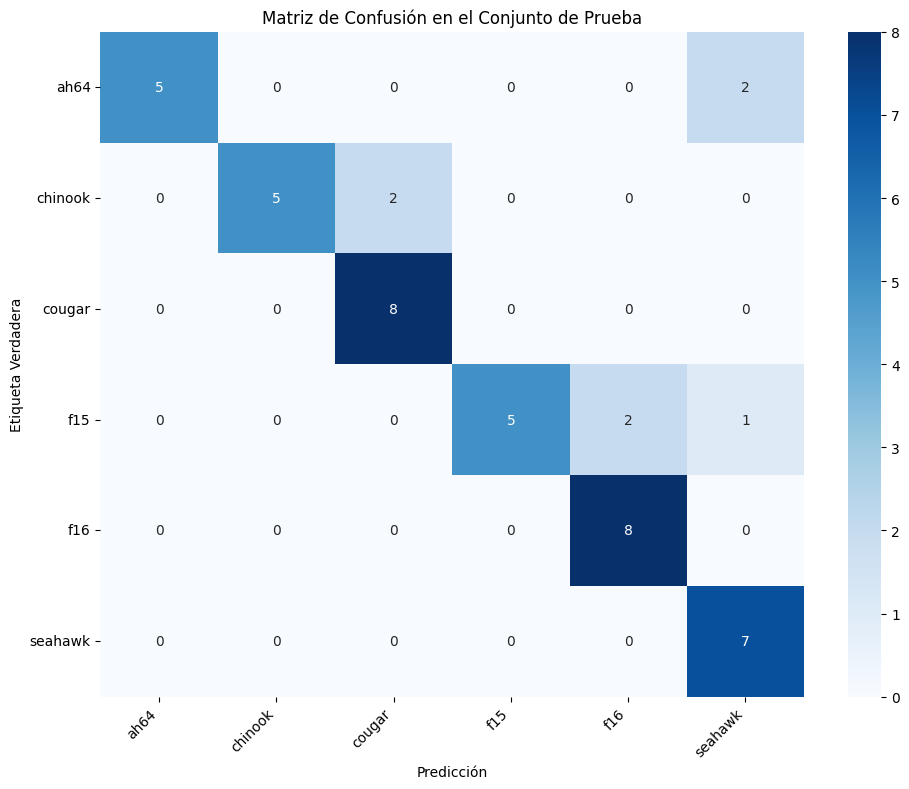

In [30]:
# Matriz de Confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nMatriz de Confusión (numpy array):")
# print(conf_matrix) # Imprimir la matriz numpy si quieres

# 4. Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
# Usar seaborn para una visualización más atractiva
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Visualización de Ejemplos de Predicción (Opcional)


--- Visualizando Ejemplos de Predicción ---
Cargando un lote del test_loader para visualización de predicciones...


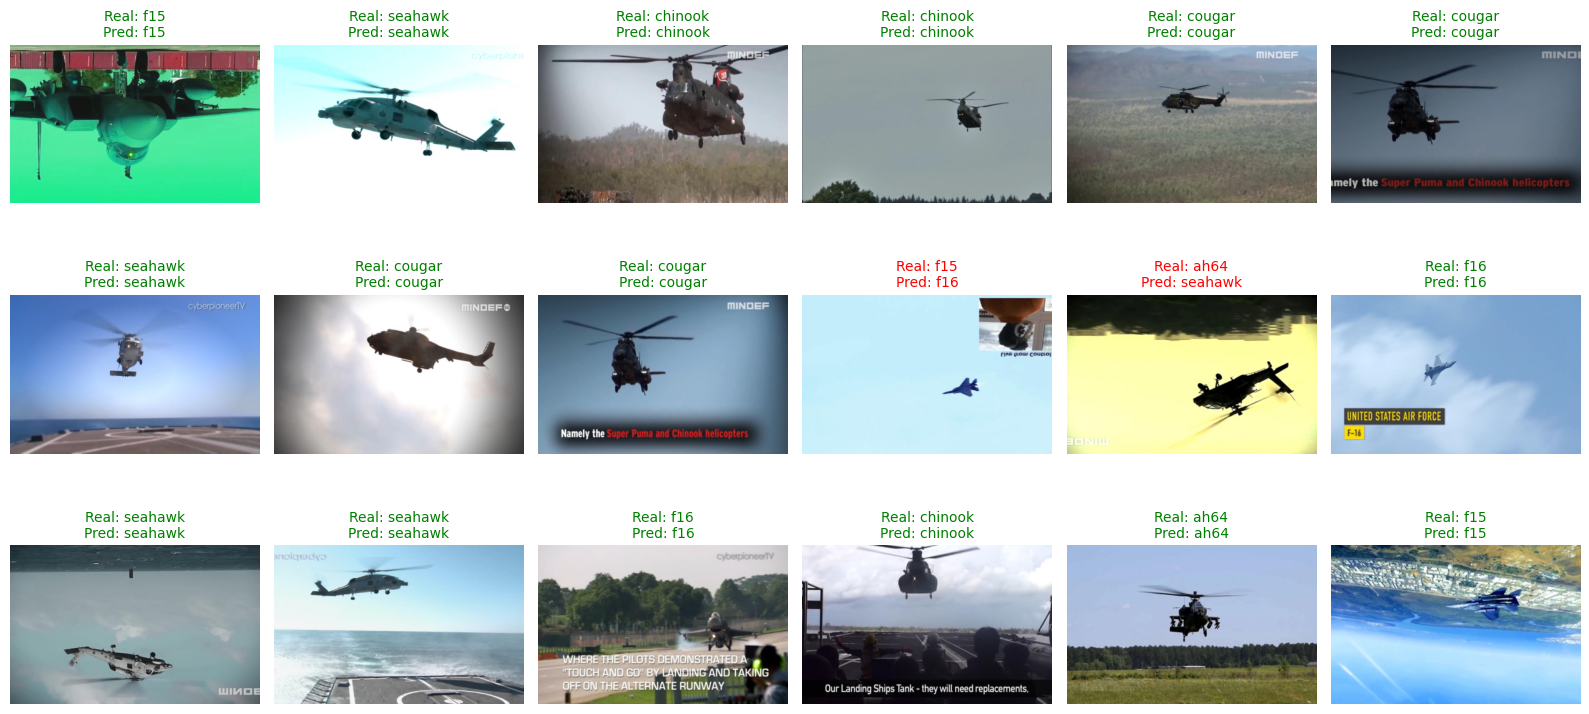

  VRAM después de visualización de ejemplos: 613.91 MB
VRAM al final del MÓDULO 7: 613.91 MB

--- Fin MÓDULO 7 ---


In [31]:
# 5. Visualización de Ejemplos de Predicción (Opcional)
print("\n--- Visualizando Ejemplos de Predicción ---")

# Función para de-normalizar una imagen (necesaria si quieres ver la imagen original)
# Esta función asume la media y std de ImageNet que usamos en M2/M3
def denormalize(tensor, mean=mean_list, std=std_list):
    """Denormaliza un tensor de imagen (C, H, W) con media y std dadas."""
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    # Asegurarse de que la media y std están en el mismo dispositivo que el tensor si es en GPU
    # Pero como la denormalización es para visualización (CPU/matplotlib), mejor pasar a CPU si tensor está en GPU
    # No necesitamos mover el tensor a CPU aquí si el input ya viene de test_images (que no movimos a device para plot)
    # tensor = tensor.cpu() # Si el input 'tensor' pudiera venir de GPU, descomentar esto
    mean = mean.cpu()
    std = std.cpu()

    # La forma en que aplicas la denormalización depende de si el tensor es un solo canal o un lote
    # Esta función espera un tensor (C, H, W) o un lote (B, C, H, W)
    if tensor.dim() == 3: # (C, H, W)
         tensor = tensor.unsqueeze(0) # Añadir dimensión de lote temporal
         denorm_tensor = tensor * std + mean
         denorm_tensor = denorm_tensor.squeeze(0) # Eliminar dimensión de lote
    elif tensor.dim() == 4: # (B, C, H, W)
         denorm_tensor = tensor * std + mean
    else:
        raise ValueError("Formato de tensor incorrecto para denormalización. Espera (C, H, W) o (B, C, H, W).")


    # Asegurar que los valores estén en el rango [0, 1] para visualización
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)
    return denorm_tensor

# Obtener algunas imágenes de ejemplo del test_loader
print("Cargando un lote del test_loader para visualización de predicciones...")
try:
    # Configurar el test_loader para no barajar y tomar el primer lote
    # Esto podría modificar el test_loader global si no tenemos cuidado,
    # mejor crear un iterador temporal o usar un lote específico.
    # Vamos a simplemente tomar el primer lote al iterar una vez.
    data_iter = iter(test_loader)
    test_images_batch, test_labels_batch = next(data_iter)

    # Hacer predicciones para este lote específico
    # Asegurarse de que el modelo está en eval y en el dispositivo
    final_model_eval.eval()
    with torch.no_grad():
         # Mover solo el lote actual al dispositivo para la predicción
         batch_images_device = test_images_batch.to(device)
         batch_outputs = final_model_eval(batch_images_device)
         _, batch_predicted = torch.max(batch_outputs.data, 1)
         batch_predicted = batch_predicted.cpu() # Mover predicciones a CPU

    # De-normalizar las imágenes para mostrarlas (pasando el tensor del batch)
    test_images_display_batch = denormalize(test_images_batch)

    # Convertir a numpy para matplotlib y permutar dimensiones (B, C, H, W) -> (B, H, W, C)
    test_images_display_batch = test_images_display_batch.permute(0, 2, 3, 1).numpy()
    test_labels_np = test_labels_batch.numpy()
    batch_predicted_np = batch_predicted.numpy()

    # Mostrar algunas imágenes con sus etiquetas verdaderas y predichas
    # Determinar cuántas imágenes mostrar (ej. un máximo de 18 en 3x6)
    num_images_to_show = min(len(test_images_display_batch), 18)
    fig, axes = plt.subplots(3, 6, figsize=(16, 8)) # Ajusta según num_images_to_show si es necesario
    axes = axes.ravel() # Aplanar la matriz de ejes

    for i in range(num_images_to_show):
        ax = axes[i]
        ax.imshow(test_images_display_batch[i])
        true_class = idx_to_class[test_labels_np[i]]
        predicted_class = idx_to_class[batch_predicted_np[i]]
        color = 'green' if true_class == predicted_class else 'red'
        title = f"Real: {true_class}\nPred: {predicted_class}"
        ax.set_title(title, color=color, fontsize=10) # Ajustar tamaño de fuente si es necesario
        ax.axis('off') # Ocultar ejes

    # Ocultar ejes restantes si mostramos menos de 18 imágenes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')


    plt.tight_layout()
    plt.show()

    # Liberar tensores
    del data_iter, test_images_batch, test_labels_batch, batch_images_device, batch_outputs, batch_predicted, test_images_display_batch, test_labels_np, batch_predicted_np
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de visualización de ejemplos: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

except Exception as e:
    print(f"\nError al intentar visualizar ejemplos de predicción: {e}")
    print("Asegúrate de que matplotlib, seaborn y torchvision están correctamente instalados y que hay suficientes imágenes en el test_loader.")


# Limpieza de memoria opcional final
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"VRAM al final del MÓDULO 7: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")


print("\n--- Fin MÓDULO 7 ---")

In [32]:
#%pip install winsound

In [33]:
import winsound
import time

# Frecuencia (Hz) y duración (ms)
frequency = 500
duration = 100
pause_duration = 0.5  # seconds

for _ in range(3):
    winsound.Beep(frequency=frequency, duration=duration)
    time.sleep(pause_duration)
